Imports And Setup

In [9]:
import os
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Device:", device)

print("🧠 PyTorch Version:", torch.__version__)
print("✅ CUDA Available:", torch.cuda.is_available())
print("🔢 CUDA Version:", torch.version.cuda)
print("🖥️ Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")


✅ Device: cuda
🧠 PyTorch Version: 2.5.1+cu121
✅ CUDA Available: True
🔢 CUDA Version: 12.1
🖥️ Device: NVIDIA GeForce RTX 3050 Laptop GPU


Split Data

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
#dataset
root_dir = r'Path\Dataset\All data'

classes = ['Awake', 'Drowsy', 'Distracted']


train_dir = r'Path\Dataset\Datasplit\train'
test_dir = r'Path\Dataset\Datasplit\test'


# train/test
for c in classes:
    os.makedirs(os.path.join(train_dir, c), exist_ok=True)
    os.makedirs(os.path.join(test_dir, c), exist_ok=True)

# Split
for c in classes:
    class_path = os.path.join(root_dir, c)
    images = os.listdir(class_path)

    train_imgs, test_imgs = train_test_split(images, test_size=0.2, random_state=42)


    for img in train_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, c, img))

    for img in test_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, c, img))

def count_images(directory):
    print(f"\n📁 ຂໍ້ມູນໃນ: {directory}")
    total = 0
    for c in classes:
        path = os.path.join(directory, c)
        num_images = len(os.listdir(path))
        print(f" - {c}: {num_images} ຮູບ")
        total += num_images
    print(f"ລວມ: {total} ຮູບ")

# Show data split
count_images(train_dir)
count_images(test_dir)


print("✅ ແບ່ງຂໍ້ມູນຮຽບຮ້ອຍແລ້ວ: Train 80% / Test 20%")



📁 ຂໍ້ມູນໃນ: D:\ບົດຮຽນ\ວິຊາຄົ້ນຄວ້າປີ3\ບົດຈົບຊັ້ນ\USB_Final\Dataset\Datasplit\train
 - Awake: 5272 ຮູບ
 - Drowsy: 5239 ຮູບ
 - Distracted: 5232 ຮູບ
รวม: 15743 ຮູບ

📁 ຂໍ້ມູນໃນ: D:\ບົດຮຽນ\ວິຊາຄົ້ນຄວ້າປີ3\ບົດຈົບຊັ້ນ\USB_Final\Dataset\Datasplit\test
 - Awake: 1318 ຮູບ
 - Drowsy: 1310 ຮູບ
 - Distracted: 1308 ຮູບ
รวม: 3936 ຮູບ
✅ ແບ່ງຂໍ້ມູນຮຽບຮ້ອຍແລ້ວ: Train 80% / Test 20%


Data Pre-Processing, Modeling, Training Process

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import copy, os

# CONFIG
BATCH_SIZE = 64
LR = 3e-5
NUM_EPOCHS = 40
PATIENCE_EARLYSTOP = 7
IMG_SIZE = 224

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🖥️ Using device:", device)

# Transform for train and validation
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Dataset
train_dataset = datasets.ImageFolder(
    r"Path\Dataset\Model_Final_Split\train",
    transform=train_transform
)
val_dataset = datasets.ImageFolder(
    r"Path\Dataset\Model_Final_Split\test",
    transform=val_transform
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("🧾 Class Mapping:", train_dataset.class_to_idx)
print(f"📊 Dataset Summary: Train={len(train_dataset)} | Val={len(val_dataset)}")

# Model (ResNet50)
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)
model.to(device)

# Optimizer, Loss, Scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Training Loop
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
train_loss_history, val_loss_history = [], []
train_acc_history, val_acc_history = [], []
early_stop_counter = 0

for epoch in range(NUM_EPOCHS):
    print(f"\n🌟 Epoch {epoch+1}/{NUM_EPOCHS}")
    model.train()
    train_loss, train_correct, total = 0.0, 0, 0

    for inputs, labels in tqdm(train_loader, desc=f"Training {epoch+1}"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += torch.sum(preds == labels.data).item()
        total += labels.size(0)

    epoch_train_loss = train_loss / total
    epoch_train_acc = train_correct / total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == labels.data).item()
            val_total += labels.size(0)

    epoch_val_loss = val_loss / val_total
    epoch_val_acc = val_correct / val_total

    # Logs
    train_loss_history.append(epoch_train_loss)
    val_loss_history.append(epoch_val_loss)
    train_acc_history.append(epoch_train_acc)
    val_acc_history.append(epoch_val_acc)

    scheduler.step(epoch_val_loss)

    print(f"✅ Train Loss: {epoch_train_loss:.4f} | Acc: {epoch_train_acc:.4f}")
    print(f"🧪 Val   Loss: {epoch_val_loss:.4f} | Acc: {epoch_val_acc:.4f}")

    # Early stopping
    if epoch_val_acc > best_acc:
        best_acc = epoch_val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        print("💾 Best model updated.")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        print(f"⚠️ EarlyStopping Trigger: {early_stop_counter}/{PATIENCE_EARLYSTOP}")

    if early_stop_counter >= PATIENCE_EARLYSTOP:
        print("⛔ EarlyStopping activated.")
        break

# ✅ Save Best Model
model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), "ResNet50.pth")
print("🎉 Model saved successfully: ResNet50.pth")


Plot Garph

In [ ]:
import matplotlib.pyplot as plt

# Garph Loss
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

# Garph Accuracy
plt.subplot(1,2,2)
plt.plot(train_acc_history, label='Train Acc')
plt.plot(val_acc_history, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.tight_layout()
plt.show()

Show Confusion Matrix

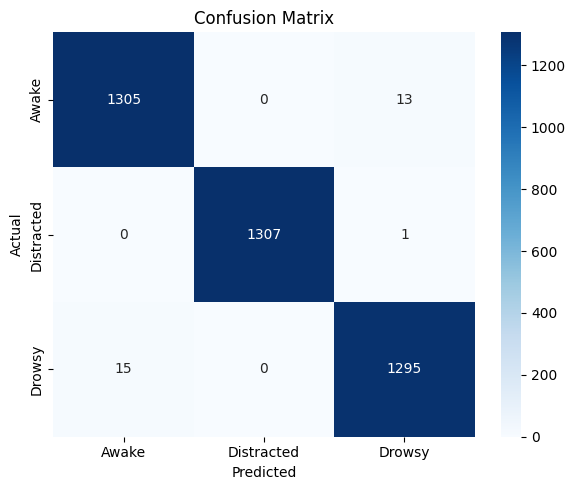

📄 Classification Report:
              precision    recall  f1-score      support
Awake          0.988636  0.990137  0.989386  1318.000000
Distracted     1.000000  0.999235  0.999618  1308.000000
Drowsy         0.989305  0.988550  0.988927  1310.000000
accuracy       0.992632  0.992632  0.992632     0.992632
macro avg      0.992647  0.992641  0.992644  3936.000000
weighted avg   0.992635  0.992632  0.992633  3936.000000


In [ ]:
# ຕັ້ງໂໝດປະເມີນ
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

class_names = ['Awake', 'Distracted', 'Drowsy']

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()

#  Classification Report
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv("classification_report.csv")
print("📄 Classification Report:")
print(report_df)


MobileNetV3lage Model

In [ ]:


import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import time, copy, os

# CONFIG
BATCH_SIZE = 64
LR = 3e-5
NUM_EPOCHS = 40
PATIENCE_EARLYSTOP = 7
IMG_SIZE = 224
NUM_CLASSES = 3  

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Dataset
train_dataset = datasets.ImageFolder(r"Path\Model_Final_Split\train", transform=train_transform)
val_dataset = datasets.ImageFolder(r"Path\Model_Final_Split\test", transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# # Model
# num_features = model.fc.in_features
# model.fc = nn.Linear(num_features, 3)
# model.to(device)

# LOAD MobileNetV3-Large
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v3_large', pretrained=True)

# MODIFY CLASSIFIER for 2 CLASS
model.classifier[3] = nn.Linear(model.classifier[3].in_features, NUM_CLASSES)
model.to(device)

# Optimizer, Loss, Scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Train Loop
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
train_loss_history, val_loss_history = [], []
train_acc_history, val_acc_history = [], []
early_stop_counter = 0

for epoch in range(NUM_EPOCHS):
    print(f"\n🌟 Epoch {epoch+1}/{NUM_EPOCHS}")
    model.train()
    train_loss, train_correct, total = 0.0, 0, 0

    for batch_idx, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}")):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += torch.sum(preds == labels.data).item()
        total += labels.size(0)

        if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(train_loader):
            batch_acc = train_correct / total
            print(f"🌀 Batch {batch_idx+1}/{len(train_loader)} - Loss: {loss.item():.4f} | Acc: {batch_acc:.4f}")

    epoch_train_loss = train_loss / total
    epoch_train_acc = train_correct / total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == labels.data).item()
            val_total += labels.size(0)

    epoch_val_loss = val_loss / val_total
    epoch_val_acc = val_correct / val_total

    train_loss_history.append(epoch_train_loss)
    val_loss_history.append(epoch_val_loss)
    train_acc_history.append(epoch_train_acc)
    val_acc_history.append(epoch_val_acc)

    scheduler.step(epoch_val_loss)

    print(f"✅ Epoch Summary -> Train Loss: {epoch_train_loss:.4f}, Accuracy: {epoch_train_acc:.4f}")
    print(f"🧪 Val Loss: {epoch_val_loss:.4f}, Accuracy: {epoch_val_acc:.4f}")

    # ✅ Save best model
    if epoch_val_acc > best_acc:
        best_acc = epoch_val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        print("✅ Best model updated.")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        print(f"⚠️ EarlyStopping Trigger: {early_stop_counter}/{PATIENCE_EARLYSTOP}")

    if early_stop_counter >= PATIENCE_EARLYSTOP:
        print("⛔ EarlyStopping activated.")
        break

# ✅ Save Final Best Model
model.load_state_dict(best_model_wts)

torch.save(model.state_dict(), "MobileNetV3.pth")
print("💾 Model saved successfully: MobileNetV3")


Using: cuda


Using cache found in C:\Users\GIGABYTE/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\GIGABYTE\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\GIGABYTE\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\GIGABYTE\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning 


🌟 Epoch 1/40


Training Epoch 1:   4%|▍         | 10/246 [00:04<01:20,  2.93it/s]

🌀 Batch 10/246 - Loss: 0.9705 | Acc: 0.4281


Training Epoch 1:   8%|▊         | 20/246 [00:07<01:14,  3.04it/s]

🌀 Batch 20/246 - Loss: 0.8769 | Acc: 0.5289


Training Epoch 1:  12%|█▏        | 30/246 [00:10<01:13,  2.95it/s]

🌀 Batch 30/246 - Loss: 0.7338 | Acc: 0.5974


Training Epoch 1:  16%|█▋        | 40/246 [00:14<01:14,  2.75it/s]

🌀 Batch 40/246 - Loss: 0.6408 | Acc: 0.6289


Training Epoch 1:  20%|██        | 50/246 [00:17<01:09,  2.80it/s]

🌀 Batch 50/246 - Loss: 0.5564 | Acc: 0.6681


Training Epoch 1:  24%|██▍       | 60/246 [00:21<01:07,  2.75it/s]

🌀 Batch 60/246 - Loss: 0.4828 | Acc: 0.6958


Training Epoch 1:  28%|██▊       | 70/246 [00:24<00:59,  2.98it/s]

🌀 Batch 70/246 - Loss: 0.3844 | Acc: 0.7210


Training Epoch 1:  33%|███▎      | 80/246 [00:28<00:57,  2.87it/s]

🌀 Batch 80/246 - Loss: 0.3394 | Acc: 0.7389


Training Epoch 1:  37%|███▋      | 90/246 [00:31<00:56,  2.74it/s]

🌀 Batch 90/246 - Loss: 0.3176 | Acc: 0.7566


Training Epoch 1:  41%|████      | 100/246 [00:35<00:52,  2.79it/s]

🌀 Batch 100/246 - Loss: 0.2502 | Acc: 0.7734


Training Epoch 1:  45%|████▍     | 110/246 [00:39<00:48,  2.80it/s]

🌀 Batch 110/246 - Loss: 0.1879 | Acc: 0.7872


Training Epoch 1:  49%|████▉     | 120/246 [00:42<00:46,  2.73it/s]

🌀 Batch 120/246 - Loss: 0.2672 | Acc: 0.7991


Training Epoch 1:  53%|█████▎    | 130/246 [00:46<00:42,  2.74it/s]

🌀 Batch 130/246 - Loss: 0.2110 | Acc: 0.8100


Training Epoch 1:  57%|█████▋    | 140/246 [00:50<00:42,  2.51it/s]

🌀 Batch 140/246 - Loss: 0.2397 | Acc: 0.8189


Training Epoch 1:  61%|██████    | 150/246 [00:53<00:36,  2.64it/s]

🌀 Batch 150/246 - Loss: 0.1388 | Acc: 0.8268


Training Epoch 1:  65%|██████▌   | 160/246 [00:57<00:30,  2.83it/s]

🌀 Batch 160/246 - Loss: 0.1097 | Acc: 0.8340


Training Epoch 1:  69%|██████▉   | 170/246 [01:00<00:26,  2.85it/s]

🌀 Batch 170/246 - Loss: 0.1109 | Acc: 0.8407


Training Epoch 1:  73%|███████▎  | 180/246 [01:04<00:22,  2.98it/s]

🌀 Batch 180/246 - Loss: 0.1296 | Acc: 0.8469


Training Epoch 1:  77%|███████▋  | 190/246 [01:07<00:20,  2.77it/s]

🌀 Batch 190/246 - Loss: 0.1055 | Acc: 0.8531


Training Epoch 1:  81%|████████▏ | 200/246 [01:11<00:15,  2.95it/s]

🌀 Batch 200/246 - Loss: 0.0865 | Acc: 0.8589


Training Epoch 1:  85%|████████▌ | 210/246 [01:14<00:12,  2.93it/s]

🌀 Batch 210/246 - Loss: 0.1551 | Acc: 0.8638


Training Epoch 1:  89%|████████▉ | 220/246 [01:18<00:08,  2.94it/s]

🌀 Batch 220/246 - Loss: 0.0839 | Acc: 0.8685


Training Epoch 1:  93%|█████████▎| 230/246 [01:21<00:05,  2.82it/s]

🌀 Batch 230/246 - Loss: 0.0874 | Acc: 0.8728


Training Epoch 1:  98%|█████████▊| 240/246 [01:25<00:02,  2.93it/s]

🌀 Batch 240/246 - Loss: 0.1447 | Acc: 0.8767


Training Epoch 1: 100%|██████████| 246/246 [01:27<00:00,  2.82it/s]

🌀 Batch 246/246 - Loss: 0.1282 | Acc: 0.8790


✅ Epoch Summary -> Train Loss: 0.3310, Accuracy: 0.8790
🧪 Val Loss: 0.0763, Accuracy: 0.9766
✅ Best model updated.

🌟 Epoch 2/40


Training Epoch 2:   4%|▍         | 10/246 [00:03<01:20,  2.95it/s]

🌀 Batch 10/246 - Loss: 0.1040 | Acc: 0.9750


Training Epoch 2:   8%|▊         | 20/246 [00:06<01:18,  2.88it/s]

🌀 Batch 20/246 - Loss: 0.1158 | Acc: 0.9789


Training Epoch 2:  12%|█▏        | 30/246 [00:10<01:13,  2.92it/s]

🌀 Batch 30/246 - Loss: 0.1053 | Acc: 0.9771


Training Epoch 2:  16%|█▋        | 40/246 [00:13<01:13,  2.80it/s]

🌀 Batch 40/246 - Loss: 0.0373 | Acc: 0.9773


Training Epoch 2:  20%|██        | 50/246 [00:17<01:07,  2.89it/s]

🌀 Batch 50/246 - Loss: 0.0860 | Acc: 0.9781


Training Epoch 2:  24%|██▍       | 60/246 [00:21<01:09,  2.67it/s]

🌀 Batch 60/246 - Loss: 0.0268 | Acc: 0.9784


Training Epoch 2:  28%|██▊       | 70/246 [00:24<01:00,  2.91it/s]

🌀 Batch 70/246 - Loss: 0.0751 | Acc: 0.9777


Training Epoch 2:  33%|███▎      | 80/246 [00:28<00:57,  2.91it/s]

🌀 Batch 80/246 - Loss: 0.0998 | Acc: 0.9777


Training Epoch 2:  37%|███▋      | 90/246 [00:31<00:57,  2.71it/s]

🌀 Batch 90/246 - Loss: 0.0447 | Acc: 0.9778


Training Epoch 2:  41%|████      | 100/246 [00:35<00:54,  2.68it/s]

🌀 Batch 100/246 - Loss: 0.0433 | Acc: 0.9781


Training Epoch 2:  45%|████▍     | 110/246 [00:39<00:50,  2.71it/s]

🌀 Batch 110/246 - Loss: 0.0759 | Acc: 0.9786


Training Epoch 2:  49%|████▉     | 120/246 [00:43<00:44,  2.82it/s]

🌀 Batch 120/246 - Loss: 0.0807 | Acc: 0.9786


Training Epoch 2:  53%|█████▎    | 130/246 [00:46<00:43,  2.64it/s]

🌀 Batch 130/246 - Loss: 0.0571 | Acc: 0.9785


Training Epoch 2:  57%|█████▋    | 140/246 [00:50<00:40,  2.59it/s]

🌀 Batch 140/246 - Loss: 0.0550 | Acc: 0.9781


Training Epoch 2:  61%|██████    | 150/246 [00:54<00:37,  2.57it/s]

🌀 Batch 150/246 - Loss: 0.0381 | Acc: 0.9781


Training Epoch 2:  65%|██████▌   | 160/246 [00:58<00:30,  2.78it/s]

🌀 Batch 160/246 - Loss: 0.0390 | Acc: 0.9772


Training Epoch 2:  69%|██████▉   | 170/246 [01:01<00:27,  2.80it/s]

🌀 Batch 170/246 - Loss: 0.0467 | Acc: 0.9778


Training Epoch 2:  73%|███████▎  | 180/246 [01:05<00:23,  2.82it/s]

🌀 Batch 180/246 - Loss: 0.0296 | Acc: 0.9784


Training Epoch 2:  77%|███████▋  | 190/246 [01:09<00:20,  2.74it/s]

🌀 Batch 190/246 - Loss: 0.0631 | Acc: 0.9788


Training Epoch 2:  81%|████████▏ | 200/246 [01:12<00:16,  2.80it/s]

🌀 Batch 200/246 - Loss: 0.0478 | Acc: 0.9788


Training Epoch 2:  85%|████████▌ | 210/246 [01:16<00:12,  2.83it/s]

🌀 Batch 210/246 - Loss: 0.0391 | Acc: 0.9791


Training Epoch 2:  89%|████████▉ | 220/246 [01:19<00:09,  2.82it/s]

🌀 Batch 220/246 - Loss: 0.0794 | Acc: 0.9790


Training Epoch 2:  93%|█████████▎| 230/246 [01:23<00:06,  2.62it/s]

🌀 Batch 230/246 - Loss: 0.0419 | Acc: 0.9788


Training Epoch 2:  98%|█████████▊| 240/246 [01:27<00:02,  2.66it/s]

🌀 Batch 240/246 - Loss: 0.0107 | Acc: 0.9788


Training Epoch 2: 100%|██████████| 246/246 [01:29<00:00,  2.75it/s]

🌀 Batch 246/246 - Loss: 0.0107 | Acc: 0.9792


✅ Epoch Summary -> Train Loss: 0.0637, Accuracy: 0.9792
🧪 Val Loss: 0.0473, Accuracy: 0.9845
✅ Best model updated.

🌟 Epoch 3/40


Training Epoch 3:   4%|▍         | 10/246 [00:03<01:26,  2.71it/s]

🌀 Batch 10/246 - Loss: 0.0134 | Acc: 0.9922


Training Epoch 3:   8%|▊         | 20/246 [00:07<01:28,  2.54it/s]

🌀 Batch 20/246 - Loss: 0.1676 | Acc: 0.9875


Training Epoch 3:  12%|█▏        | 30/246 [00:11<01:27,  2.47it/s]

🌀 Batch 30/246 - Loss: 0.0877 | Acc: 0.9859


Training Epoch 3:  16%|█▋        | 40/246 [00:16<01:28,  2.33it/s]

🌀 Batch 40/246 - Loss: 0.1016 | Acc: 0.9859


Training Epoch 3:  20%|██        | 50/246 [00:20<01:15,  2.58it/s]

🌀 Batch 50/246 - Loss: 0.1522 | Acc: 0.9853


Training Epoch 3:  24%|██▍       | 60/246 [00:23<01:06,  2.81it/s]

🌀 Batch 60/246 - Loss: 0.0747 | Acc: 0.9854


Training Epoch 3:  28%|██▊       | 70/246 [00:27<01:02,  2.82it/s]

🌀 Batch 70/246 - Loss: 0.0078 | Acc: 0.9868


Training Epoch 3:  33%|███▎      | 80/246 [00:30<00:59,  2.80it/s]

🌀 Batch 80/246 - Loss: 0.0294 | Acc: 0.9863


Training Epoch 3:  37%|███▋      | 90/246 [00:34<00:56,  2.76it/s]

🌀 Batch 90/246 - Loss: 0.0307 | Acc: 0.9865


Training Epoch 3:  41%|████      | 100/246 [00:37<00:50,  2.89it/s]

🌀 Batch 100/246 - Loss: 0.0569 | Acc: 0.9861


Training Epoch 3:  45%|████▍     | 110/246 [00:41<00:48,  2.82it/s]

🌀 Batch 110/246 - Loss: 0.0705 | Acc: 0.9862


Training Epoch 3:  49%|████▉     | 120/246 [00:44<00:45,  2.80it/s]

🌀 Batch 120/246 - Loss: 0.0280 | Acc: 0.9859


Training Epoch 3:  53%|█████▎    | 130/246 [00:48<00:41,  2.77it/s]

🌀 Batch 130/246 - Loss: 0.0776 | Acc: 0.9862


Training Epoch 3:  57%|█████▋    | 140/246 [00:52<00:38,  2.76it/s]

🌀 Batch 140/246 - Loss: 0.0409 | Acc: 0.9860


Training Epoch 3:  61%|██████    | 150/246 [00:55<00:34,  2.82it/s]

🌀 Batch 150/246 - Loss: 0.0828 | Acc: 0.9857


Training Epoch 3:  65%|██████▌   | 160/246 [00:59<00:31,  2.75it/s]

🌀 Batch 160/246 - Loss: 0.0190 | Acc: 0.9858


Training Epoch 3:  69%|██████▉   | 170/246 [01:03<00:26,  2.84it/s]

🌀 Batch 170/246 - Loss: 0.0099 | Acc: 0.9863


Training Epoch 3:  73%|███████▎  | 180/246 [01:06<00:24,  2.72it/s]

🌀 Batch 180/246 - Loss: 0.0131 | Acc: 0.9864


Training Epoch 3:  77%|███████▋  | 190/246 [01:10<00:20,  2.80it/s]

🌀 Batch 190/246 - Loss: 0.0643 | Acc: 0.9866


Training Epoch 3:  81%|████████▏ | 200/246 [01:13<00:16,  2.82it/s]

🌀 Batch 200/246 - Loss: 0.0340 | Acc: 0.9866


Training Epoch 3:  85%|████████▌ | 210/246 [01:17<00:12,  2.78it/s]

🌀 Batch 210/246 - Loss: 0.1866 | Acc: 0.9863


Training Epoch 3:  89%|████████▉ | 220/246 [01:20<00:09,  2.84it/s]

🌀 Batch 220/246 - Loss: 0.0577 | Acc: 0.9864


Training Epoch 3:  93%|█████████▎| 230/246 [01:24<00:05,  2.76it/s]

🌀 Batch 230/246 - Loss: 0.0082 | Acc: 0.9865


Training Epoch 3:  98%|█████████▊| 240/246 [01:28<00:02,  2.71it/s]

🌀 Batch 240/246 - Loss: 0.0090 | Acc: 0.9865


Training Epoch 3: 100%|██████████| 246/246 [01:30<00:00,  2.72it/s]


🌀 Batch 246/246 - Loss: 0.0235 | Acc: 0.9864
✅ Epoch Summary -> Train Loss: 0.0438, Accuracy: 0.9864
🧪 Val Loss: 0.0424, Accuracy: 0.9868
✅ Best model updated.

🌟 Epoch 4/40


Training Epoch 4:   4%|▍         | 10/246 [00:03<01:23,  2.84it/s]

🌀 Batch 10/246 - Loss: 0.0113 | Acc: 0.9828


Training Epoch 4:   8%|▊         | 20/246 [00:07<01:21,  2.79it/s]

🌀 Batch 20/246 - Loss: 0.0060 | Acc: 0.9875


Training Epoch 4:  12%|█▏        | 30/246 [00:10<01:16,  2.81it/s]

🌀 Batch 30/246 - Loss: 0.0371 | Acc: 0.9870


Training Epoch 4:  16%|█▋        | 40/246 [00:14<01:16,  2.68it/s]

🌀 Batch 40/246 - Loss: 0.0317 | Acc: 0.9879


Training Epoch 4:  20%|██        | 50/246 [00:18<01:13,  2.68it/s]

🌀 Batch 50/246 - Loss: 0.0177 | Acc: 0.9891


Training Epoch 4:  24%|██▍       | 60/246 [00:21<01:06,  2.81it/s]

🌀 Batch 60/246 - Loss: 0.0070 | Acc: 0.9875


Training Epoch 4:  28%|██▊       | 70/246 [00:25<01:00,  2.91it/s]

🌀 Batch 70/246 - Loss: 0.1082 | Acc: 0.9877


Training Epoch 4:  33%|███▎      | 80/246 [00:28<01:02,  2.65it/s]

🌀 Batch 80/246 - Loss: 0.0551 | Acc: 0.9875


Training Epoch 4:  37%|███▋      | 90/246 [00:32<00:55,  2.83it/s]

🌀 Batch 90/246 - Loss: 0.0128 | Acc: 0.9861


Training Epoch 4:  41%|████      | 100/246 [00:35<00:50,  2.89it/s]

🌀 Batch 100/246 - Loss: 0.0103 | Acc: 0.9866


Training Epoch 4:  45%|████▍     | 110/246 [00:39<00:48,  2.83it/s]

🌀 Batch 110/246 - Loss: 0.0146 | Acc: 0.9861


Training Epoch 4:  49%|████▉     | 120/246 [00:43<00:45,  2.76it/s]

🌀 Batch 120/246 - Loss: 0.0244 | Acc: 0.9865


Training Epoch 4:  53%|█████▎    | 130/246 [00:46<00:41,  2.79it/s]

🌀 Batch 130/246 - Loss: 0.0168 | Acc: 0.9865


Training Epoch 4:  57%|█████▋    | 140/246 [00:50<00:39,  2.69it/s]

🌀 Batch 140/246 - Loss: 0.0066 | Acc: 0.9868


Training Epoch 4:  61%|██████    | 150/246 [00:54<00:36,  2.61it/s]

🌀 Batch 150/246 - Loss: 0.0111 | Acc: 0.9870


Training Epoch 4:  65%|██████▌   | 160/246 [00:58<00:32,  2.67it/s]

🌀 Batch 160/246 - Loss: 0.0366 | Acc: 0.9873


Training Epoch 4:  69%|██████▉   | 170/246 [01:01<00:28,  2.71it/s]

🌀 Batch 170/246 - Loss: 0.0480 | Acc: 0.9869


Training Epoch 4:  73%|███████▎  | 180/246 [01:05<00:25,  2.63it/s]

🌀 Batch 180/246 - Loss: 0.0229 | Acc: 0.9872


Training Epoch 4:  77%|███████▋  | 190/246 [01:09<00:20,  2.69it/s]

🌀 Batch 190/246 - Loss: 0.0274 | Acc: 0.9873


Training Epoch 4:  81%|████████▏ | 200/246 [01:13<00:16,  2.79it/s]

🌀 Batch 200/246 - Loss: 0.0072 | Acc: 0.9879


Training Epoch 4:  85%|████████▌ | 210/246 [01:16<00:13,  2.66it/s]

🌀 Batch 210/246 - Loss: 0.0104 | Acc: 0.9879


Training Epoch 4:  89%|████████▉ | 220/246 [01:20<00:09,  2.81it/s]

🌀 Batch 220/246 - Loss: 0.0984 | Acc: 0.9879


Training Epoch 4:  93%|█████████▎| 230/246 [01:23<00:05,  2.82it/s]

🌀 Batch 230/246 - Loss: 0.0069 | Acc: 0.9878


Training Epoch 4:  98%|█████████▊| 240/246 [01:27<00:02,  2.56it/s]

🌀 Batch 240/246 - Loss: 0.0777 | Acc: 0.9879


Training Epoch 4: 100%|██████████| 246/246 [01:29<00:00,  2.74it/s]

🌀 Batch 246/246 - Loss: 0.0146 | Acc: 0.9879


✅ Epoch Summary -> Train Loss: 0.0389, Accuracy: 0.9879
🧪 Val Loss: 0.0340, Accuracy: 0.9898
✅ Best model updated.

🌟 Epoch 5/40


Training Epoch 5:   4%|▍         | 10/246 [00:03<01:22,  2.86it/s]

🌀 Batch 10/246 - Loss: 0.0042 | Acc: 0.9906


Training Epoch 5:   8%|▊         | 20/246 [00:07<01:20,  2.79it/s]

🌀 Batch 20/246 - Loss: 0.0292 | Acc: 0.9906


Training Epoch 5:  12%|█▏        | 30/246 [00:10<01:16,  2.84it/s]

🌀 Batch 30/246 - Loss: 0.0427 | Acc: 0.9896


Training Epoch 5:  16%|█▋        | 40/246 [00:14<01:14,  2.77it/s]

🌀 Batch 40/246 - Loss: 0.0202 | Acc: 0.9895


Training Epoch 5:  20%|██        | 50/246 [00:18<01:10,  2.77it/s]

🌀 Batch 50/246 - Loss: 0.0116 | Acc: 0.9906


Training Epoch 5:  24%|██▍       | 60/246 [00:21<01:14,  2.50it/s]

🌀 Batch 60/246 - Loss: 0.0337 | Acc: 0.9906


Training Epoch 5:  28%|██▊       | 70/246 [00:25<01:06,  2.66it/s]

🌀 Batch 70/246 - Loss: 0.0268 | Acc: 0.9902


Training Epoch 5:  33%|███▎      | 80/246 [00:29<01:06,  2.49it/s]

🌀 Batch 80/246 - Loss: 0.0123 | Acc: 0.9898


Training Epoch 5:  37%|███▋      | 90/246 [00:33<01:02,  2.50it/s]

🌀 Batch 90/246 - Loss: 0.0221 | Acc: 0.9898


Training Epoch 5:  41%|████      | 100/246 [00:37<00:57,  2.52it/s]

🌀 Batch 100/246 - Loss: 0.0224 | Acc: 0.9897


Training Epoch 5:  45%|████▍     | 110/246 [00:41<00:49,  2.74it/s]

🌀 Batch 110/246 - Loss: 0.0264 | Acc: 0.9899


Training Epoch 5:  49%|████▉     | 120/246 [00:44<00:44,  2.83it/s]

🌀 Batch 120/246 - Loss: 0.0557 | Acc: 0.9889


Training Epoch 5:  53%|█████▎    | 130/246 [00:48<00:40,  2.85it/s]

🌀 Batch 130/246 - Loss: 0.0060 | Acc: 0.9885


Training Epoch 5:  57%|█████▋    | 140/246 [00:51<00:38,  2.72it/s]

🌀 Batch 140/246 - Loss: 0.0065 | Acc: 0.9888


Training Epoch 5:  61%|██████    | 150/246 [00:55<00:35,  2.74it/s]

🌀 Batch 150/246 - Loss: 0.0324 | Acc: 0.9888


Training Epoch 5:  65%|██████▌   | 160/246 [00:59<00:31,  2.74it/s]

🌀 Batch 160/246 - Loss: 0.0282 | Acc: 0.9888


Training Epoch 5:  69%|██████▉   | 170/246 [01:03<00:27,  2.78it/s]

🌀 Batch 170/246 - Loss: 0.0066 | Acc: 0.9888


Training Epoch 5:  73%|███████▎  | 180/246 [01:06<00:23,  2.84it/s]

🌀 Batch 180/246 - Loss: 0.0564 | Acc: 0.9891


Training Epoch 5:  77%|███████▋  | 190/246 [01:10<00:20,  2.68it/s]

🌀 Batch 190/246 - Loss: 0.0104 | Acc: 0.9894


Training Epoch 5:  81%|████████▏ | 200/246 [01:13<00:16,  2.75it/s]

🌀 Batch 200/246 - Loss: 0.0268 | Acc: 0.9893


Training Epoch 5:  85%|████████▌ | 210/246 [01:17<00:13,  2.75it/s]

🌀 Batch 210/246 - Loss: 0.0132 | Acc: 0.9894


Training Epoch 5:  89%|████████▉ | 220/246 [01:21<00:09,  2.83it/s]

🌀 Batch 220/246 - Loss: 0.0229 | Acc: 0.9894


Training Epoch 5:  93%|█████████▎| 230/246 [01:24<00:05,  2.83it/s]

🌀 Batch 230/246 - Loss: 0.0492 | Acc: 0.9894


Training Epoch 5:  98%|█████████▊| 240/246 [01:28<00:02,  2.68it/s]

🌀 Batch 240/246 - Loss: 0.0443 | Acc: 0.9894


Training Epoch 5: 100%|██████████| 246/246 [01:30<00:00,  2.72it/s]

🌀 Batch 246/246 - Loss: 0.0093 | Acc: 0.9893


✅ Epoch Summary -> Train Loss: 0.0317, Accuracy: 0.9893
🧪 Val Loss: 0.0358, Accuracy: 0.9893
⚠️ EarlyStopping Trigger: 1/7

🌟 Epoch 6/40


Training Epoch 6:   4%|▍         | 10/246 [00:03<01:26,  2.73it/s]

🌀 Batch 10/246 - Loss: 0.0093 | Acc: 0.9859


Training Epoch 6:   8%|▊         | 20/246 [00:07<01:26,  2.62it/s]

🌀 Batch 20/246 - Loss: 0.0020 | Acc: 0.9898


Training Epoch 6:  12%|█▏        | 30/246 [00:11<01:20,  2.69it/s]

🌀 Batch 30/246 - Loss: 0.0701 | Acc: 0.9891


Training Epoch 6:  16%|█▋        | 40/246 [00:14<01:14,  2.77it/s]

🌀 Batch 40/246 - Loss: 0.0084 | Acc: 0.9902


Training Epoch 6:  20%|██        | 50/246 [00:18<01:14,  2.62it/s]

🌀 Batch 50/246 - Loss: 0.0269 | Acc: 0.9900


Training Epoch 6:  24%|██▍       | 60/246 [00:22<01:12,  2.57it/s]

🌀 Batch 60/246 - Loss: 0.0196 | Acc: 0.9901


Training Epoch 6:  28%|██▊       | 70/246 [00:26<01:08,  2.58it/s]

🌀 Batch 70/246 - Loss: 0.0042 | Acc: 0.9902


Training Epoch 6:  33%|███▎      | 80/246 [00:30<01:04,  2.58it/s]

🌀 Batch 80/246 - Loss: 0.0857 | Acc: 0.9900


Training Epoch 6:  37%|███▋      | 90/246 [00:34<01:00,  2.57it/s]

🌀 Batch 90/246 - Loss: 0.0050 | Acc: 0.9898


Training Epoch 6:  41%|████      | 100/246 [00:38<00:53,  2.73it/s]

🌀 Batch 100/246 - Loss: 0.0124 | Acc: 0.9903


Training Epoch 6:  45%|████▍     | 110/246 [00:41<00:50,  2.67it/s]

🌀 Batch 110/246 - Loss: 0.0142 | Acc: 0.9908


Training Epoch 6:  49%|████▉     | 120/246 [00:45<00:47,  2.64it/s]

🌀 Batch 120/246 - Loss: 0.0536 | Acc: 0.9902


Training Epoch 6:  53%|█████▎    | 130/246 [00:49<00:43,  2.65it/s]

🌀 Batch 130/246 - Loss: 0.0144 | Acc: 0.9899


Training Epoch 6:  57%|█████▋    | 140/246 [00:53<00:40,  2.62it/s]

🌀 Batch 140/246 - Loss: 0.0163 | Acc: 0.9901


Training Epoch 6:  61%|██████    | 150/246 [00:56<00:36,  2.64it/s]

🌀 Batch 150/246 - Loss: 0.0304 | Acc: 0.9898


Training Epoch 6:  65%|██████▌   | 160/246 [01:00<00:32,  2.63it/s]

🌀 Batch 160/246 - Loss: 0.0037 | Acc: 0.9901


Training Epoch 6:  69%|██████▉   | 170/246 [01:04<00:28,  2.64it/s]

🌀 Batch 170/246 - Loss: 0.0122 | Acc: 0.9902


Training Epoch 6:  73%|███████▎  | 180/246 [01:08<00:25,  2.64it/s]

🌀 Batch 180/246 - Loss: 0.0035 | Acc: 0.9898


Training Epoch 6:  77%|███████▋  | 190/246 [01:12<00:21,  2.64it/s]

🌀 Batch 190/246 - Loss: 0.0285 | Acc: 0.9901


Training Epoch 6:  81%|████████▏ | 200/246 [01:15<00:17,  2.65it/s]

🌀 Batch 200/246 - Loss: 0.0946 | Acc: 0.9902


Training Epoch 6:  85%|████████▌ | 210/246 [01:19<00:13,  2.66it/s]

🌀 Batch 210/246 - Loss: 0.0318 | Acc: 0.9903


Training Epoch 6:  89%|████████▉ | 220/246 [01:23<00:09,  2.86it/s]

🌀 Batch 220/246 - Loss: 0.0056 | Acc: 0.9903


Training Epoch 6:  93%|█████████▎| 230/246 [01:26<00:05,  2.89it/s]

🌀 Batch 230/246 - Loss: 0.0104 | Acc: 0.9901


Training Epoch 6:  98%|█████████▊| 240/246 [01:30<00:02,  2.86it/s]

🌀 Batch 240/246 - Loss: 0.0181 | Acc: 0.9902


Training Epoch 6: 100%|██████████| 246/246 [01:32<00:00,  2.66it/s]

🌀 Batch 246/246 - Loss: 0.0636 | Acc: 0.9903


✅ Epoch Summary -> Train Loss: 0.0279, Accuracy: 0.9903
🧪 Val Loss: 0.0347, Accuracy: 0.9901
✅ Best model updated.

🌟 Epoch 7/40


Training Epoch 7:   4%|▍         | 10/246 [00:03<01:21,  2.88it/s]

🌀 Batch 10/246 - Loss: 0.0103 | Acc: 0.9875


Training Epoch 7:   8%|▊         | 20/246 [00:06<01:18,  2.87it/s]

🌀 Batch 20/246 - Loss: 0.0015 | Acc: 0.9914


Training Epoch 7:  12%|█▏        | 30/246 [00:10<01:16,  2.84it/s]

🌀 Batch 30/246 - Loss: 0.0281 | Acc: 0.9911


Training Epoch 7:  16%|█▋        | 40/246 [00:14<01:15,  2.74it/s]

🌀 Batch 40/246 - Loss: 0.0101 | Acc: 0.9930


Training Epoch 7:  20%|██        | 50/246 [00:17<01:18,  2.50it/s]

🌀 Batch 50/246 - Loss: 0.0030 | Acc: 0.9925


Training Epoch 7:  24%|██▍       | 60/246 [00:21<01:07,  2.74it/s]

🌀 Batch 60/246 - Loss: 0.0022 | Acc: 0.9919


Training Epoch 7:  28%|██▊       | 70/246 [00:25<01:01,  2.86it/s]

🌀 Batch 70/246 - Loss: 0.0061 | Acc: 0.9917


Training Epoch 7:  33%|███▎      | 80/246 [00:28<00:58,  2.84it/s]

🌀 Batch 80/246 - Loss: 0.0058 | Acc: 0.9920


Training Epoch 7:  37%|███▋      | 90/246 [00:32<00:55,  2.83it/s]

🌀 Batch 90/246 - Loss: 0.0701 | Acc: 0.9920


Training Epoch 7:  41%|████      | 100/246 [00:35<00:52,  2.76it/s]

🌀 Batch 100/246 - Loss: 0.0296 | Acc: 0.9912


Training Epoch 7:  45%|████▍     | 110/246 [00:39<00:48,  2.80it/s]

🌀 Batch 110/246 - Loss: 0.0415 | Acc: 0.9915


Training Epoch 7:  49%|████▉     | 120/246 [00:42<00:43,  2.87it/s]

🌀 Batch 120/246 - Loss: 0.0316 | Acc: 0.9913


Training Epoch 7:  53%|█████▎    | 130/246 [00:46<00:39,  2.93it/s]

🌀 Batch 130/246 - Loss: 0.0385 | Acc: 0.9915


Training Epoch 7:  57%|█████▋    | 140/246 [00:49<00:36,  2.92it/s]

🌀 Batch 140/246 - Loss: 0.0070 | Acc: 0.9915


Training Epoch 7:  61%|██████    | 150/246 [00:53<00:33,  2.90it/s]

🌀 Batch 150/246 - Loss: 0.0681 | Acc: 0.9912


Training Epoch 7:  65%|██████▌   | 160/246 [00:56<00:29,  2.93it/s]

🌀 Batch 160/246 - Loss: 0.0208 | Acc: 0.9909


Training Epoch 7:  69%|██████▉   | 170/246 [01:00<00:27,  2.81it/s]

🌀 Batch 170/246 - Loss: 0.0065 | Acc: 0.9912


Training Epoch 7:  73%|███████▎  | 180/246 [01:03<00:22,  2.90it/s]

🌀 Batch 180/246 - Loss: 0.0361 | Acc: 0.9912


Training Epoch 7:  77%|███████▋  | 190/246 [01:07<00:19,  2.85it/s]

🌀 Batch 190/246 - Loss: 0.0347 | Acc: 0.9914


Training Epoch 7:  81%|████████▏ | 200/246 [01:10<00:17,  2.65it/s]

🌀 Batch 200/246 - Loss: 0.0012 | Acc: 0.9915


Training Epoch 7:  85%|████████▌ | 210/246 [01:14<00:12,  2.77it/s]

🌀 Batch 210/246 - Loss: 0.0017 | Acc: 0.9912


Training Epoch 7:  89%|████████▉ | 220/246 [01:17<00:09,  2.82it/s]

🌀 Batch 220/246 - Loss: 0.0167 | Acc: 0.9913


Training Epoch 7:  93%|█████████▎| 230/246 [01:21<00:05,  2.85it/s]

🌀 Batch 230/246 - Loss: 0.1616 | Acc: 0.9911


Training Epoch 7:  98%|█████████▊| 240/246 [01:25<00:02,  2.72it/s]

🌀 Batch 240/246 - Loss: 0.0177 | Acc: 0.9910


Training Epoch 7: 100%|██████████| 246/246 [01:27<00:00,  2.81it/s]

🌀 Batch 246/246 - Loss: 0.0109 | Acc: 0.9910


✅ Epoch Summary -> Train Loss: 0.0251, Accuracy: 0.9910
🧪 Val Loss: 0.0322, Accuracy: 0.9898
⚠️ EarlyStopping Trigger: 1/7

🌟 Epoch 8/40


Training Epoch 8:   4%|▍         | 10/246 [00:03<01:20,  2.93it/s]

🌀 Batch 10/246 - Loss: 0.0128 | Acc: 0.9922


Training Epoch 8:   8%|▊         | 20/246 [00:06<01:17,  2.92it/s]

🌀 Batch 20/246 - Loss: 0.0015 | Acc: 0.9922


Training Epoch 8:  12%|█▏        | 30/246 [00:10<01:15,  2.85it/s]

🌀 Batch 30/246 - Loss: 0.0066 | Acc: 0.9938


Training Epoch 8:  16%|█▋        | 40/246 [00:13<01:11,  2.89it/s]

🌀 Batch 40/246 - Loss: 0.0091 | Acc: 0.9945


Training Epoch 8:  20%|██        | 50/246 [00:17<01:07,  2.91it/s]

🌀 Batch 50/246 - Loss: 0.0051 | Acc: 0.9938


Training Epoch 8:  24%|██▍       | 60/246 [00:20<01:05,  2.84it/s]

🌀 Batch 60/246 - Loss: 0.0176 | Acc: 0.9935


Training Epoch 8:  28%|██▊       | 70/246 [00:24<01:02,  2.80it/s]

🌀 Batch 70/246 - Loss: 0.0730 | Acc: 0.9926


Training Epoch 8:  33%|███▎      | 80/246 [00:27<00:58,  2.84it/s]

🌀 Batch 80/246 - Loss: 0.0230 | Acc: 0.9926


Training Epoch 8:  37%|███▋      | 90/246 [00:31<00:54,  2.86it/s]

🌀 Batch 90/246 - Loss: 0.0015 | Acc: 0.9924


Training Epoch 8:  41%|████      | 100/246 [00:34<00:51,  2.82it/s]

🌀 Batch 100/246 - Loss: 0.0030 | Acc: 0.9919


Training Epoch 8:  45%|████▍     | 110/246 [00:38<00:47,  2.83it/s]

🌀 Batch 110/246 - Loss: 0.0054 | Acc: 0.9922


Training Epoch 8:  49%|████▉     | 120/246 [00:42<00:44,  2.83it/s]

🌀 Batch 120/246 - Loss: 0.0122 | Acc: 0.9926


Training Epoch 8:  53%|█████▎    | 130/246 [00:45<00:39,  2.90it/s]

🌀 Batch 130/246 - Loss: 0.0092 | Acc: 0.9925


Training Epoch 8:  57%|█████▋    | 140/246 [00:48<00:36,  2.87it/s]

🌀 Batch 140/246 - Loss: 0.0461 | Acc: 0.9927


Training Epoch 8:  61%|██████    | 150/246 [00:52<00:33,  2.90it/s]

🌀 Batch 150/246 - Loss: 0.0296 | Acc: 0.9925


Training Epoch 8:  65%|██████▌   | 160/246 [00:56<00:29,  2.88it/s]

🌀 Batch 160/246 - Loss: 0.0022 | Acc: 0.9927


Training Epoch 8:  69%|██████▉   | 170/246 [00:59<00:26,  2.88it/s]

🌀 Batch 170/246 - Loss: 0.0255 | Acc: 0.9925


Training Epoch 8:  73%|███████▎  | 180/246 [01:03<00:23,  2.84it/s]

🌀 Batch 180/246 - Loss: 0.0044 | Acc: 0.9924


Training Epoch 8:  77%|███████▋  | 190/246 [01:06<00:19,  2.85it/s]

🌀 Batch 190/246 - Loss: 0.0025 | Acc: 0.9926


Training Epoch 8:  81%|████████▏ | 200/246 [01:10<00:16,  2.74it/s]

🌀 Batch 200/246 - Loss: 0.0429 | Acc: 0.9927


Training Epoch 8:  85%|████████▌ | 210/246 [01:13<00:13,  2.68it/s]

🌀 Batch 210/246 - Loss: 0.0034 | Acc: 0.9929


Training Epoch 8:  89%|████████▉ | 220/246 [01:17<00:09,  2.70it/s]

🌀 Batch 220/246 - Loss: 0.0029 | Acc: 0.9930


Training Epoch 8:  93%|█████████▎| 230/246 [01:21<00:05,  2.79it/s]

🌀 Batch 230/246 - Loss: 0.0449 | Acc: 0.9928


Training Epoch 8:  98%|█████████▊| 240/246 [01:25<00:02,  2.67it/s]

🌀 Batch 240/246 - Loss: 0.0042 | Acc: 0.9929


Training Epoch 8: 100%|██████████| 246/246 [01:27<00:00,  2.81it/s]

🌀 Batch 246/246 - Loss: 0.1017 | Acc: 0.9928


✅ Epoch Summary -> Train Loss: 0.0208, Accuracy: 0.9928
🧪 Val Loss: 0.0323, Accuracy: 0.9898
⚠️ EarlyStopping Trigger: 2/7

🌟 Epoch 9/40


Training Epoch 9:   4%|▍         | 10/246 [00:03<01:22,  2.87it/s]

🌀 Batch 10/246 - Loss: 0.0024 | Acc: 0.9984


Training Epoch 9:   8%|▊         | 20/246 [00:06<01:18,  2.88it/s]

🌀 Batch 20/246 - Loss: 0.0833 | Acc: 0.9938


Training Epoch 9:  12%|█▏        | 30/246 [00:10<01:16,  2.83it/s]

🌀 Batch 30/246 - Loss: 0.0135 | Acc: 0.9948


Training Epoch 9:  16%|█▋        | 40/246 [00:13<01:10,  2.91it/s]

🌀 Batch 40/246 - Loss: 0.0054 | Acc: 0.9949


Training Epoch 9:  20%|██        | 50/246 [00:17<01:08,  2.86it/s]

🌀 Batch 50/246 - Loss: 0.0107 | Acc: 0.9947


Training Epoch 9:  24%|██▍       | 60/246 [00:20<01:03,  2.94it/s]

🌀 Batch 60/246 - Loss: 0.0456 | Acc: 0.9940


Training Epoch 9:  28%|██▊       | 70/246 [00:24<01:01,  2.85it/s]

🌀 Batch 70/246 - Loss: 0.0136 | Acc: 0.9933


Training Epoch 9:  33%|███▎      | 80/246 [00:27<00:58,  2.82it/s]

🌀 Batch 80/246 - Loss: 0.0150 | Acc: 0.9934


Training Epoch 9:  37%|███▋      | 90/246 [00:31<00:54,  2.86it/s]

🌀 Batch 90/246 - Loss: 0.0110 | Acc: 0.9932


Training Epoch 9:  41%|████      | 100/246 [00:34<00:49,  2.94it/s]

🌀 Batch 100/246 - Loss: 0.0022 | Acc: 0.9934


Training Epoch 9:  45%|████▍     | 110/246 [00:38<00:46,  2.89it/s]

🌀 Batch 110/246 - Loss: 0.0034 | Acc: 0.9938


Training Epoch 9:  49%|████▉     | 120/246 [00:41<00:44,  2.86it/s]

🌀 Batch 120/246 - Loss: 0.0037 | Acc: 0.9939


Training Epoch 9:  53%|█████▎    | 130/246 [00:45<00:42,  2.76it/s]

🌀 Batch 130/246 - Loss: 0.0102 | Acc: 0.9940


Training Epoch 9:  57%|█████▋    | 140/246 [00:49<00:36,  2.87it/s]

🌀 Batch 140/246 - Loss: 0.0364 | Acc: 0.9940


Training Epoch 9:  61%|██████    | 150/246 [00:52<00:35,  2.73it/s]

🌀 Batch 150/246 - Loss: 0.0285 | Acc: 0.9933


Training Epoch 9:  65%|██████▌   | 160/246 [00:56<00:29,  2.90it/s]

🌀 Batch 160/246 - Loss: 0.0051 | Acc: 0.9932


Training Epoch 9:  69%|██████▉   | 170/246 [00:59<00:26,  2.87it/s]

🌀 Batch 170/246 - Loss: 0.0459 | Acc: 0.9930


Training Epoch 9:  73%|███████▎  | 180/246 [01:03<00:23,  2.86it/s]

🌀 Batch 180/246 - Loss: 0.0735 | Acc: 0.9931


Training Epoch 9:  77%|███████▋  | 190/246 [01:06<00:21,  2.64it/s]

🌀 Batch 190/246 - Loss: 0.0372 | Acc: 0.9932


Training Epoch 9:  81%|████████▏ | 200/246 [01:10<00:16,  2.79it/s]

🌀 Batch 200/246 - Loss: 0.0250 | Acc: 0.9929


Training Epoch 9:  85%|████████▌ | 210/246 [01:14<00:13,  2.64it/s]

🌀 Batch 210/246 - Loss: 0.0170 | Acc: 0.9929


Training Epoch 9:  89%|████████▉ | 220/246 [01:17<00:09,  2.70it/s]

🌀 Batch 220/246 - Loss: 0.0189 | Acc: 0.9930


Training Epoch 9:  93%|█████████▎| 230/246 [01:21<00:05,  2.75it/s]

🌀 Batch 230/246 - Loss: 0.0323 | Acc: 0.9929


Training Epoch 9:  98%|█████████▊| 240/246 [01:25<00:02,  2.80it/s]

🌀 Batch 240/246 - Loss: 0.0532 | Acc: 0.9929


Training Epoch 9: 100%|██████████| 246/246 [01:27<00:00,  2.82it/s]

🌀 Batch 246/246 - Loss: 0.0134 | Acc: 0.9930


✅ Epoch Summary -> Train Loss: 0.0202, Accuracy: 0.9930
🧪 Val Loss: 0.0326, Accuracy: 0.9891
⚠️ EarlyStopping Trigger: 3/7

🌟 Epoch 10/40


Training Epoch 10:   4%|▍         | 10/246 [00:03<01:23,  2.82it/s]

🌀 Batch 10/246 - Loss: 0.0040 | Acc: 0.9938


Training Epoch 10:   8%|▊         | 20/246 [00:07<01:18,  2.89it/s]

🌀 Batch 20/246 - Loss: 0.0058 | Acc: 0.9938


Training Epoch 10:  12%|█▏        | 30/246 [00:10<01:15,  2.85it/s]

🌀 Batch 30/246 - Loss: 0.0125 | Acc: 0.9948


Training Epoch 10:  16%|█▋        | 40/246 [00:14<01:18,  2.61it/s]

🌀 Batch 40/246 - Loss: 0.0018 | Acc: 0.9953


Training Epoch 10:  20%|██        | 50/246 [00:17<01:13,  2.67it/s]

🌀 Batch 50/246 - Loss: 0.0994 | Acc: 0.9950


Training Epoch 10:  24%|██▍       | 60/246 [00:21<01:06,  2.82it/s]

🌀 Batch 60/246 - Loss: 0.0502 | Acc: 0.9951


Training Epoch 10:  28%|██▊       | 70/246 [00:25<01:04,  2.75it/s]

🌀 Batch 70/246 - Loss: 0.0234 | Acc: 0.9949


Training Epoch 10:  33%|███▎      | 80/246 [00:28<00:59,  2.79it/s]

🌀 Batch 80/246 - Loss: 0.0047 | Acc: 0.9949


Training Epoch 10:  37%|███▋      | 90/246 [00:32<00:55,  2.81it/s]

🌀 Batch 90/246 - Loss: 0.0198 | Acc: 0.9948


Training Epoch 10:  41%|████      | 100/246 [00:35<00:53,  2.74it/s]

🌀 Batch 100/246 - Loss: 0.0016 | Acc: 0.9942


Training Epoch 10:  45%|████▍     | 110/246 [00:39<00:48,  2.79it/s]

🌀 Batch 110/246 - Loss: 0.0161 | Acc: 0.9943


Training Epoch 10:  49%|████▉     | 120/246 [00:43<00:44,  2.84it/s]

🌀 Batch 120/246 - Loss: 0.0046 | Acc: 0.9944


Training Epoch 10:  53%|█████▎    | 130/246 [00:46<00:41,  2.82it/s]

🌀 Batch 130/246 - Loss: 0.0077 | Acc: 0.9941


Training Epoch 10:  57%|█████▋    | 140/246 [00:50<00:36,  2.89it/s]

🌀 Batch 140/246 - Loss: 0.0276 | Acc: 0.9941


Training Epoch 10:  61%|██████    | 150/246 [00:53<00:36,  2.61it/s]

🌀 Batch 150/246 - Loss: 0.0124 | Acc: 0.9936


Training Epoch 10:  65%|██████▌   | 160/246 [00:57<00:31,  2.75it/s]

🌀 Batch 160/246 - Loss: 0.0034 | Acc: 0.9937


Training Epoch 10:  69%|██████▉   | 170/246 [01:01<00:27,  2.79it/s]

🌀 Batch 170/246 - Loss: 0.0138 | Acc: 0.9936


Training Epoch 10:  73%|███████▎  | 180/246 [01:04<00:22,  2.87it/s]

🌀 Batch 180/246 - Loss: 0.0556 | Acc: 0.9934


Training Epoch 10:  77%|███████▋  | 190/246 [01:08<00:19,  2.88it/s]

🌀 Batch 190/246 - Loss: 0.0217 | Acc: 0.9932


Training Epoch 10:  81%|████████▏ | 200/246 [01:11<00:15,  2.98it/s]

🌀 Batch 200/246 - Loss: 0.0385 | Acc: 0.9931


Training Epoch 10:  85%|████████▌ | 210/246 [01:15<00:12,  2.91it/s]

🌀 Batch 210/246 - Loss: 0.0158 | Acc: 0.9932


Training Epoch 10:  89%|████████▉ | 220/246 [01:18<00:08,  2.92it/s]

🌀 Batch 220/246 - Loss: 0.0040 | Acc: 0.9933


Training Epoch 10:  93%|█████████▎| 230/246 [01:21<00:05,  2.97it/s]

🌀 Batch 230/246 - Loss: 0.0089 | Acc: 0.9935


Training Epoch 10:  98%|█████████▊| 240/246 [01:25<00:02,  2.97it/s]

🌀 Batch 240/246 - Loss: 0.0071 | Acc: 0.9937


Training Epoch 10: 100%|██████████| 246/246 [01:27<00:00,  2.82it/s]

🌀 Batch 246/246 - Loss: 0.0179 | Acc: 0.9938


✅ Epoch Summary -> Train Loss: 0.0177, Accuracy: 0.9938
🧪 Val Loss: 0.0336, Accuracy: 0.9909
✅ Best model updated.

🌟 Epoch 11/40


Training Epoch 11:   4%|▍         | 10/246 [00:03<01:19,  2.95it/s]

🌀 Batch 10/246 - Loss: 0.0084 | Acc: 0.9922


Training Epoch 11:   8%|▊         | 20/246 [00:06<01:16,  2.96it/s]

🌀 Batch 20/246 - Loss: 0.0198 | Acc: 0.9875


Training Epoch 11:  12%|█▏        | 30/246 [00:10<01:11,  3.00it/s]

🌀 Batch 30/246 - Loss: 0.0083 | Acc: 0.9911


Training Epoch 11:  16%|█▋        | 40/246 [00:13<01:09,  2.96it/s]

🌀 Batch 40/246 - Loss: 0.0028 | Acc: 0.9930


Training Epoch 11:  20%|██        | 50/246 [00:17<01:06,  2.93it/s]

🌀 Batch 50/246 - Loss: 0.0015 | Acc: 0.9941


Training Epoch 11:  24%|██▍       | 60/246 [00:20<01:04,  2.90it/s]

🌀 Batch 60/246 - Loss: 0.0920 | Acc: 0.9943


Training Epoch 11:  28%|██▊       | 70/246 [00:23<01:02,  2.82it/s]

🌀 Batch 70/246 - Loss: 0.0423 | Acc: 0.9942


Training Epoch 11:  33%|███▎      | 80/246 [00:27<00:56,  2.96it/s]

🌀 Batch 80/246 - Loss: 0.0417 | Acc: 0.9945


Training Epoch 11:  37%|███▋      | 90/246 [00:30<00:53,  2.94it/s]

🌀 Batch 90/246 - Loss: 0.0040 | Acc: 0.9943


Training Epoch 11:  41%|████      | 100/246 [00:34<00:50,  2.89it/s]

🌀 Batch 100/246 - Loss: 0.0025 | Acc: 0.9945


Training Epoch 11:  45%|████▍     | 110/246 [00:37<00:47,  2.87it/s]

🌀 Batch 110/246 - Loss: 0.0015 | Acc: 0.9940


Training Epoch 11:  49%|████▉     | 120/246 [00:41<00:42,  2.96it/s]

🌀 Batch 120/246 - Loss: 0.0254 | Acc: 0.9941


Training Epoch 11:  53%|█████▎    | 130/246 [00:44<00:39,  2.91it/s]

🌀 Batch 130/246 - Loss: 0.0143 | Acc: 0.9945


Training Epoch 11:  57%|█████▋    | 140/246 [00:48<00:36,  2.91it/s]

🌀 Batch 140/246 - Loss: 0.0060 | Acc: 0.9946


Training Epoch 11:  61%|██████    | 150/246 [00:51<00:33,  2.83it/s]

🌀 Batch 150/246 - Loss: 0.0638 | Acc: 0.9947


Training Epoch 11:  65%|██████▌   | 160/246 [00:55<00:30,  2.86it/s]

🌀 Batch 160/246 - Loss: 0.0332 | Acc: 0.9946


Training Epoch 11:  69%|██████▉   | 170/246 [00:58<00:25,  2.93it/s]

🌀 Batch 170/246 - Loss: 0.0140 | Acc: 0.9946


Training Epoch 11:  73%|███████▎  | 180/246 [01:01<00:22,  2.95it/s]

🌀 Batch 180/246 - Loss: 0.0019 | Acc: 0.9948


Training Epoch 11:  77%|███████▋  | 190/246 [01:05<00:18,  2.98it/s]

🌀 Batch 190/246 - Loss: 0.0011 | Acc: 0.9951


Training Epoch 11:  81%|████████▏ | 200/246 [01:08<00:15,  2.92it/s]

🌀 Batch 200/246 - Loss: 0.0013 | Acc: 0.9949


Training Epoch 11:  85%|████████▌ | 210/246 [01:12<00:12,  2.91it/s]

🌀 Batch 210/246 - Loss: 0.0102 | Acc: 0.9949


Training Epoch 11:  89%|████████▉ | 220/246 [01:15<00:08,  2.96it/s]

🌀 Batch 220/246 - Loss: 0.0089 | Acc: 0.9947


Training Epoch 11:  93%|█████████▎| 230/246 [01:18<00:05,  2.97it/s]

🌀 Batch 230/246 - Loss: 0.0187 | Acc: 0.9948


Training Epoch 11:  98%|█████████▊| 240/246 [01:22<00:02,  2.89it/s]

🌀 Batch 240/246 - Loss: 0.0127 | Acc: 0.9946


Training Epoch 11: 100%|██████████| 246/246 [01:24<00:00,  2.92it/s]

🌀 Batch 246/246 - Loss: 0.0025 | Acc: 0.9947


✅ Epoch Summary -> Train Loss: 0.0162, Accuracy: 0.9947
🧪 Val Loss: 0.0297, Accuracy: 0.9911
✅ Best model updated.

🌟 Epoch 12/40


Training Epoch 12:   4%|▍         | 10/246 [00:03<01:20,  2.93it/s]

🌀 Batch 10/246 - Loss: 0.0396 | Acc: 0.9953


Training Epoch 12:   8%|▊         | 20/246 [00:06<01:18,  2.87it/s]

🌀 Batch 20/246 - Loss: 0.0017 | Acc: 0.9977


Training Epoch 12:  12%|█▏        | 30/246 [00:10<01:13,  2.96it/s]

🌀 Batch 30/246 - Loss: 0.0287 | Acc: 0.9969


Training Epoch 12:  16%|█▋        | 40/246 [00:13<01:11,  2.89it/s]

🌀 Batch 40/246 - Loss: 0.0158 | Acc: 0.9969


Training Epoch 12:  20%|██        | 50/246 [00:17<01:07,  2.90it/s]

🌀 Batch 50/246 - Loss: 0.0165 | Acc: 0.9969


Training Epoch 12:  24%|██▍       | 60/246 [00:20<01:03,  2.95it/s]

🌀 Batch 60/246 - Loss: 0.0025 | Acc: 0.9966


Training Epoch 12:  28%|██▊       | 70/246 [00:24<01:00,  2.92it/s]

🌀 Batch 70/246 - Loss: 0.0267 | Acc: 0.9964


Training Epoch 12:  33%|███▎      | 80/246 [00:27<00:56,  2.91it/s]

🌀 Batch 80/246 - Loss: 0.0046 | Acc: 0.9959


Training Epoch 12:  37%|███▋      | 90/246 [00:30<00:52,  2.97it/s]

🌀 Batch 90/246 - Loss: 0.0085 | Acc: 0.9958


Training Epoch 12:  41%|████      | 100/246 [00:34<00:49,  2.96it/s]

🌀 Batch 100/246 - Loss: 0.0100 | Acc: 0.9962


Training Epoch 12:  45%|████▍     | 110/246 [00:37<00:46,  2.95it/s]

🌀 Batch 110/246 - Loss: 0.0021 | Acc: 0.9963


Training Epoch 12:  49%|████▉     | 120/246 [00:40<00:42,  2.94it/s]

🌀 Batch 120/246 - Loss: 0.0077 | Acc: 0.9954


Training Epoch 12:  53%|█████▎    | 130/246 [00:44<00:39,  2.93it/s]

🌀 Batch 130/246 - Loss: 0.0959 | Acc: 0.9951


Training Epoch 12:  57%|█████▋    | 140/246 [00:47<00:35,  2.96it/s]

🌀 Batch 140/246 - Loss: 0.0022 | Acc: 0.9950


Training Epoch 12:  61%|██████    | 150/246 [00:51<00:32,  2.92it/s]

🌀 Batch 150/246 - Loss: 0.0026 | Acc: 0.9950


Training Epoch 12:  65%|██████▌   | 160/246 [00:54<00:29,  2.89it/s]

🌀 Batch 160/246 - Loss: 0.0027 | Acc: 0.9951


Training Epoch 12:  69%|██████▉   | 170/246 [00:58<00:25,  3.00it/s]

🌀 Batch 170/246 - Loss: 0.0384 | Acc: 0.9951


Training Epoch 12:  73%|███████▎  | 180/246 [01:01<00:22,  2.95it/s]

🌀 Batch 180/246 - Loss: 0.0018 | Acc: 0.9951


Training Epoch 12:  77%|███████▋  | 190/246 [01:04<00:19,  2.91it/s]

🌀 Batch 190/246 - Loss: 0.0093 | Acc: 0.9949


Training Epoch 12:  81%|████████▏ | 200/246 [01:08<00:15,  2.92it/s]

🌀 Batch 200/246 - Loss: 0.0030 | Acc: 0.9950


Training Epoch 12:  85%|████████▌ | 210/246 [01:11<00:12,  2.85it/s]

🌀 Batch 210/246 - Loss: 0.0181 | Acc: 0.9949


Training Epoch 12:  89%|████████▉ | 220/246 [01:15<00:09,  2.85it/s]

🌀 Batch 220/246 - Loss: 0.0108 | Acc: 0.9952


Training Epoch 12:  93%|█████████▎| 230/246 [01:18<00:05,  2.92it/s]

🌀 Batch 230/246 - Loss: 0.0013 | Acc: 0.9950


Training Epoch 12:  98%|█████████▊| 240/246 [01:22<00:02,  2.94it/s]

🌀 Batch 240/246 - Loss: 0.0056 | Acc: 0.9949


Training Epoch 12: 100%|██████████| 246/246 [01:24<00:00,  2.92it/s]

🌀 Batch 246/246 - Loss: 0.0060 | Acc: 0.9950


✅ Epoch Summary -> Train Loss: 0.0145, Accuracy: 0.9950
🧪 Val Loss: 0.0315, Accuracy: 0.9906
⚠️ EarlyStopping Trigger: 1/7

🌟 Epoch 13/40


Training Epoch 13:   4%|▍         | 10/246 [00:03<01:21,  2.91it/s]

🌀 Batch 10/246 - Loss: 0.0018 | Acc: 0.9969


Training Epoch 13:   8%|▊         | 20/246 [00:06<01:16,  2.95it/s]

🌀 Batch 20/246 - Loss: 0.0032 | Acc: 0.9977


Training Epoch 13:  12%|█▏        | 30/246 [00:10<01:17,  2.78it/s]

🌀 Batch 30/246 - Loss: 0.0011 | Acc: 0.9964


Training Epoch 13:  16%|█▋        | 40/246 [00:14<01:15,  2.74it/s]

🌀 Batch 40/246 - Loss: 0.0106 | Acc: 0.9961


Training Epoch 13:  20%|██        | 50/246 [00:17<01:12,  2.71it/s]

🌀 Batch 50/246 - Loss: 0.0544 | Acc: 0.9950


Training Epoch 13:  24%|██▍       | 60/246 [00:21<01:05,  2.85it/s]

🌀 Batch 60/246 - Loss: 0.0025 | Acc: 0.9956


Training Epoch 13:  28%|██▊       | 70/246 [00:24<01:02,  2.80it/s]

🌀 Batch 70/246 - Loss: 0.0145 | Acc: 0.9962


Training Epoch 13:  33%|███▎      | 80/246 [00:28<00:57,  2.88it/s]

🌀 Batch 80/246 - Loss: 0.0014 | Acc: 0.9961


Training Epoch 13:  37%|███▋      | 90/246 [00:31<00:56,  2.75it/s]

🌀 Batch 90/246 - Loss: 0.0103 | Acc: 0.9957


Training Epoch 13:  41%|████      | 100/246 [00:35<00:51,  2.83it/s]

🌀 Batch 100/246 - Loss: 0.0055 | Acc: 0.9958


Training Epoch 13:  45%|████▍     | 110/246 [00:39<00:49,  2.76it/s]

🌀 Batch 110/246 - Loss: 0.0066 | Acc: 0.9955


Training Epoch 13:  49%|████▉     | 120/246 [00:42<00:45,  2.76it/s]

🌀 Batch 120/246 - Loss: 0.0017 | Acc: 0.9956


Training Epoch 13:  53%|█████▎    | 130/246 [00:46<00:41,  2.77it/s]

🌀 Batch 130/246 - Loss: 0.0167 | Acc: 0.9953


Training Epoch 13:  57%|█████▋    | 140/246 [00:49<00:38,  2.78it/s]

🌀 Batch 140/246 - Loss: 0.0198 | Acc: 0.9953


Training Epoch 13:  61%|██████    | 150/246 [00:53<00:34,  2.78it/s]

🌀 Batch 150/246 - Loss: 0.0014 | Acc: 0.9951


Training Epoch 13:  65%|██████▌   | 160/246 [00:57<00:31,  2.76it/s]

🌀 Batch 160/246 - Loss: 0.0037 | Acc: 0.9949


Training Epoch 13:  69%|██████▉   | 170/246 [01:00<00:27,  2.78it/s]

🌀 Batch 170/246 - Loss: 0.0146 | Acc: 0.9949


Training Epoch 13:  73%|███████▎  | 180/246 [01:04<00:24,  2.73it/s]

🌀 Batch 180/246 - Loss: 0.0007 | Acc: 0.9951


Training Epoch 13:  77%|███████▋  | 190/246 [01:07<00:20,  2.76it/s]

🌀 Batch 190/246 - Loss: 0.0020 | Acc: 0.9948


Training Epoch 13:  81%|████████▏ | 200/246 [01:11<00:16,  2.78it/s]

🌀 Batch 200/246 - Loss: 0.0037 | Acc: 0.9950


Training Epoch 13:  85%|████████▌ | 210/246 [01:15<00:12,  2.80it/s]

🌀 Batch 210/246 - Loss: 0.0214 | Acc: 0.9950


Training Epoch 13:  89%|████████▉ | 220/246 [01:18<00:09,  2.87it/s]

🌀 Batch 220/246 - Loss: 0.0142 | Acc: 0.9952


Training Epoch 13:  93%|█████████▎| 230/246 [01:22<00:05,  2.79it/s]

🌀 Batch 230/246 - Loss: 0.0085 | Acc: 0.9953


Training Epoch 13:  98%|█████████▊| 240/246 [01:26<00:02,  2.65it/s]

🌀 Batch 240/246 - Loss: 0.0034 | Acc: 0.9954


Training Epoch 13: 100%|██████████| 246/246 [01:28<00:00,  2.78it/s]

🌀 Batch 246/246 - Loss: 0.0678 | Acc: 0.9954


✅ Epoch Summary -> Train Loss: 0.0139, Accuracy: 0.9954
🧪 Val Loss: 0.0328, Accuracy: 0.9903
⚠️ EarlyStopping Trigger: 2/7

🌟 Epoch 14/40


Training Epoch 14:   4%|▍         | 10/246 [00:03<01:23,  2.83it/s]

🌀 Batch 10/246 - Loss: 0.0007 | Acc: 0.9969


Training Epoch 14:   8%|▊         | 20/246 [00:07<01:22,  2.74it/s]

🌀 Batch 20/246 - Loss: 0.0464 | Acc: 0.9953


Training Epoch 14:  12%|█▏        | 30/246 [00:10<01:16,  2.81it/s]

🌀 Batch 30/246 - Loss: 0.0009 | Acc: 0.9964


Training Epoch 14:  16%|█▋        | 40/246 [00:14<01:13,  2.79it/s]

🌀 Batch 40/246 - Loss: 0.0006 | Acc: 0.9957


Training Epoch 14:  20%|██        | 50/246 [00:17<01:10,  2.79it/s]

🌀 Batch 50/246 - Loss: 0.0008 | Acc: 0.9956


Training Epoch 14:  24%|██▍       | 60/246 [00:21<01:05,  2.83it/s]

🌀 Batch 60/246 - Loss: 0.0008 | Acc: 0.9951


Training Epoch 14:  28%|██▊       | 70/246 [00:24<01:00,  2.90it/s]

🌀 Batch 70/246 - Loss: 0.0034 | Acc: 0.9955


Training Epoch 14:  33%|███▎      | 80/246 [00:28<00:58,  2.84it/s]

🌀 Batch 80/246 - Loss: 0.0182 | Acc: 0.9949


Training Epoch 14:  37%|███▋      | 90/246 [00:32<00:56,  2.74it/s]

🌀 Batch 90/246 - Loss: 0.0116 | Acc: 0.9950


Training Epoch 14:  41%|████      | 100/246 [00:35<00:54,  2.68it/s]

🌀 Batch 100/246 - Loss: 0.0091 | Acc: 0.9953


Training Epoch 14:  45%|████▍     | 110/246 [00:39<00:49,  2.74it/s]

🌀 Batch 110/246 - Loss: 0.0296 | Acc: 0.9955


Training Epoch 14:  49%|████▉     | 120/246 [00:43<00:46,  2.69it/s]

🌀 Batch 120/246 - Loss: 0.0077 | Acc: 0.9952


Training Epoch 14:  53%|█████▎    | 130/246 [00:46<00:41,  2.77it/s]

🌀 Batch 130/246 - Loss: 0.0005 | Acc: 0.9953


Training Epoch 14:  57%|█████▋    | 140/246 [00:50<00:37,  2.83it/s]

🌀 Batch 140/246 - Loss: 0.0014 | Acc: 0.9955


Training Epoch 14:  61%|██████    | 150/246 [00:53<00:33,  2.84it/s]

🌀 Batch 150/246 - Loss: 0.0014 | Acc: 0.9956


Training Epoch 14:  65%|██████▌   | 160/246 [00:57<00:30,  2.83it/s]

🌀 Batch 160/246 - Loss: 0.0040 | Acc: 0.9955


Training Epoch 14:  69%|██████▉   | 170/246 [01:00<00:27,  2.81it/s]

🌀 Batch 170/246 - Loss: 0.0251 | Acc: 0.9956


Training Epoch 14:  73%|███████▎  | 180/246 [01:04<00:23,  2.84it/s]

🌀 Batch 180/246 - Loss: 0.0006 | Acc: 0.9957


Training Epoch 14:  77%|███████▋  | 190/246 [01:07<00:19,  2.90it/s]

🌀 Batch 190/246 - Loss: 0.0008 | Acc: 0.9958


Training Epoch 14:  81%|████████▏ | 200/246 [01:11<00:16,  2.82it/s]

🌀 Batch 200/246 - Loss: 0.0305 | Acc: 0.9958


Training Epoch 14:  85%|████████▌ | 210/246 [01:15<00:12,  2.79it/s]

🌀 Batch 210/246 - Loss: 0.0082 | Acc: 0.9958


Training Epoch 14:  89%|████████▉ | 220/246 [01:18<00:09,  2.88it/s]

🌀 Batch 220/246 - Loss: 0.0551 | Acc: 0.9955


Training Epoch 14:  93%|█████████▎| 230/246 [01:22<00:05,  2.80it/s]

🌀 Batch 230/246 - Loss: 0.0060 | Acc: 0.9954


Training Epoch 14:  98%|█████████▊| 240/246 [01:25<00:02,  2.86it/s]

🌀 Batch 240/246 - Loss: 0.0251 | Acc: 0.9954


Training Epoch 14: 100%|██████████| 246/246 [01:27<00:00,  2.81it/s]

🌀 Batch 246/246 - Loss: 0.0042 | Acc: 0.9954


✅ Epoch Summary -> Train Loss: 0.0131, Accuracy: 0.9954
🧪 Val Loss: 0.0318, Accuracy: 0.9906
⚠️ EarlyStopping Trigger: 3/7

🌟 Epoch 15/40


Training Epoch 15:   4%|▍         | 10/246 [00:03<01:25,  2.77it/s]

🌀 Batch 10/246 - Loss: 0.0118 | Acc: 0.9984


Training Epoch 15:   8%|▊         | 20/246 [00:07<01:20,  2.79it/s]

🌀 Batch 20/246 - Loss: 0.0068 | Acc: 0.9953


Training Epoch 15:  12%|█▏        | 30/246 [00:10<01:15,  2.87it/s]

🌀 Batch 30/246 - Loss: 0.0075 | Acc: 0.9958


Training Epoch 15:  16%|█▋        | 40/246 [00:14<01:12,  2.86it/s]

🌀 Batch 40/246 - Loss: 0.0165 | Acc: 0.9961


Training Epoch 15:  20%|██        | 50/246 [00:17<01:07,  2.92it/s]

🌀 Batch 50/246 - Loss: 0.0066 | Acc: 0.9966


Training Epoch 15:  24%|██▍       | 60/246 [00:21<01:03,  2.91it/s]

🌀 Batch 60/246 - Loss: 0.0030 | Acc: 0.9969


Training Epoch 15:  28%|██▊       | 70/246 [00:24<01:00,  2.89it/s]

🌀 Batch 70/246 - Loss: 0.0168 | Acc: 0.9971


Training Epoch 15:  33%|███▎      | 80/246 [00:28<00:59,  2.79it/s]

🌀 Batch 80/246 - Loss: 0.0281 | Acc: 0.9963


Training Epoch 15:  37%|███▋      | 90/246 [00:31<00:59,  2.60it/s]

🌀 Batch 90/246 - Loss: 0.0230 | Acc: 0.9964


Training Epoch 15:  41%|████      | 100/246 [00:35<00:52,  2.80it/s]

🌀 Batch 100/246 - Loss: 0.0020 | Acc: 0.9964


Training Epoch 15:  45%|████▍     | 110/246 [00:39<00:51,  2.62it/s]

🌀 Batch 110/246 - Loss: 0.0186 | Acc: 0.9962


Training Epoch 15:  49%|████▉     | 120/246 [00:42<00:43,  2.88it/s]

🌀 Batch 120/246 - Loss: 0.0033 | Acc: 0.9962


Training Epoch 15:  53%|█████▎    | 130/246 [00:46<00:41,  2.79it/s]

🌀 Batch 130/246 - Loss: 0.0455 | Acc: 0.9960


Training Epoch 15:  57%|█████▋    | 140/246 [00:50<00:38,  2.77it/s]

🌀 Batch 140/246 - Loss: 0.0113 | Acc: 0.9961


Training Epoch 15:  61%|██████    | 150/246 [00:53<00:34,  2.79it/s]

🌀 Batch 150/246 - Loss: 0.0040 | Acc: 0.9962


Training Epoch 15:  65%|██████▌   | 160/246 [00:56<00:29,  2.94it/s]

🌀 Batch 160/246 - Loss: 0.0102 | Acc: 0.9961


Training Epoch 15:  69%|██████▉   | 170/246 [01:00<00:26,  2.92it/s]

🌀 Batch 170/246 - Loss: 0.0022 | Acc: 0.9960


Training Epoch 15:  73%|███████▎  | 180/246 [01:03<00:23,  2.85it/s]

🌀 Batch 180/246 - Loss: 0.0014 | Acc: 0.9959


Training Epoch 15:  77%|███████▋  | 190/246 [01:07<00:19,  2.93it/s]

🌀 Batch 190/246 - Loss: 0.0425 | Acc: 0.9960


Training Epoch 15:  81%|████████▏ | 200/246 [01:10<00:15,  2.92it/s]

🌀 Batch 200/246 - Loss: 0.0554 | Acc: 0.9958


Training Epoch 15:  85%|████████▌ | 210/246 [01:14<00:12,  2.91it/s]

🌀 Batch 210/246 - Loss: 0.0006 | Acc: 0.9957


Training Epoch 15:  89%|████████▉ | 220/246 [01:17<00:08,  2.91it/s]

🌀 Batch 220/246 - Loss: 0.0064 | Acc: 0.9957


Training Epoch 15:  93%|█████████▎| 230/246 [01:21<00:05,  2.93it/s]

🌀 Batch 230/246 - Loss: 0.0007 | Acc: 0.9959


Training Epoch 15:  98%|█████████▊| 240/246 [01:24<00:02,  2.93it/s]

🌀 Batch 240/246 - Loss: 0.0473 | Acc: 0.9958


Training Epoch 15: 100%|██████████| 246/246 [01:26<00:00,  2.84it/s]

🌀 Batch 246/246 - Loss: 0.0170 | Acc: 0.9957


✅ Epoch Summary -> Train Loss: 0.0116, Accuracy: 0.9957
🧪 Val Loss: 0.0305, Accuracy: 0.9914
✅ Best model updated.

🌟 Epoch 16/40


Training Epoch 16:   4%|▍         | 10/246 [00:03<01:21,  2.90it/s]

🌀 Batch 10/246 - Loss: 0.0282 | Acc: 0.9969


Training Epoch 16:   8%|▊         | 20/246 [00:06<01:16,  2.94it/s]

🌀 Batch 20/246 - Loss: 0.0034 | Acc: 0.9969


Training Epoch 16:  12%|█▏        | 30/246 [00:10<01:20,  2.67it/s]

🌀 Batch 30/246 - Loss: 0.0028 | Acc: 0.9958


Training Epoch 16:  16%|█▋        | 40/246 [00:14<01:11,  2.87it/s]

🌀 Batch 40/246 - Loss: 0.0349 | Acc: 0.9945


Training Epoch 16:  20%|██        | 50/246 [00:17<01:07,  2.91it/s]

🌀 Batch 50/246 - Loss: 0.0127 | Acc: 0.9956


Training Epoch 16:  24%|██▍       | 60/246 [00:20<01:03,  2.94it/s]

🌀 Batch 60/246 - Loss: 0.0053 | Acc: 0.9958


Training Epoch 16:  28%|██▊       | 70/246 [00:24<01:00,  2.89it/s]

🌀 Batch 70/246 - Loss: 0.0031 | Acc: 0.9955


Training Epoch 16:  33%|███▎      | 80/246 [00:27<00:56,  2.96it/s]

🌀 Batch 80/246 - Loss: 0.0008 | Acc: 0.9951


Training Epoch 16:  37%|███▋      | 90/246 [00:31<00:52,  2.97it/s]

🌀 Batch 90/246 - Loss: 0.0079 | Acc: 0.9951


Training Epoch 16:  41%|████      | 100/246 [00:34<00:52,  2.76it/s]

🌀 Batch 100/246 - Loss: 0.0108 | Acc: 0.9947


Training Epoch 16:  45%|████▍     | 110/246 [00:38<00:47,  2.88it/s]

🌀 Batch 110/246 - Loss: 0.0024 | Acc: 0.9947


Training Epoch 16:  49%|████▉     | 120/246 [00:41<00:43,  2.92it/s]

🌀 Batch 120/246 - Loss: 0.0008 | Acc: 0.9948


Training Epoch 16:  53%|█████▎    | 130/246 [00:45<00:39,  2.96it/s]

🌀 Batch 130/246 - Loss: 0.0105 | Acc: 0.9948


Training Epoch 16:  57%|█████▋    | 140/246 [00:48<00:36,  2.90it/s]

🌀 Batch 140/246 - Loss: 0.0641 | Acc: 0.9951


Training Epoch 16:  61%|██████    | 150/246 [00:52<00:35,  2.70it/s]

🌀 Batch 150/246 - Loss: 0.0071 | Acc: 0.9954


Training Epoch 16:  65%|██████▌   | 160/246 [00:55<00:31,  2.77it/s]

🌀 Batch 160/246 - Loss: 0.0199 | Acc: 0.9956


Training Epoch 16:  69%|██████▉   | 170/246 [00:59<00:26,  2.88it/s]

🌀 Batch 170/246 - Loss: 0.0021 | Acc: 0.9957


Training Epoch 16:  73%|███████▎  | 180/246 [01:02<00:23,  2.86it/s]

🌀 Batch 180/246 - Loss: 0.0027 | Acc: 0.9955


Training Epoch 16:  77%|███████▋  | 190/246 [01:06<00:18,  3.07it/s]

🌀 Batch 190/246 - Loss: 0.0033 | Acc: 0.9954


Training Epoch 16:  81%|████████▏ | 200/246 [01:09<00:15,  2.93it/s]

🌀 Batch 200/246 - Loss: 0.0035 | Acc: 0.9955


Training Epoch 16:  85%|████████▌ | 210/246 [01:13<00:12,  2.81it/s]

🌀 Batch 210/246 - Loss: 0.0038 | Acc: 0.9956


Training Epoch 16:  89%|████████▉ | 220/246 [01:16<00:09,  2.76it/s]

🌀 Batch 220/246 - Loss: 0.0024 | Acc: 0.9955


Training Epoch 16:  93%|█████████▎| 230/246 [01:20<00:05,  2.89it/s]

🌀 Batch 230/246 - Loss: 0.0015 | Acc: 0.9954


Training Epoch 16:  98%|█████████▊| 240/246 [01:23<00:02,  2.72it/s]

🌀 Batch 240/246 - Loss: 0.0701 | Acc: 0.9951


Training Epoch 16: 100%|██████████| 246/246 [01:25<00:00,  2.86it/s]

🌀 Batch 246/246 - Loss: 0.0065 | Acc: 0.9951


✅ Epoch Summary -> Train Loss: 0.0120, Accuracy: 0.9951
🧪 Val Loss: 0.0305, Accuracy: 0.9914
⚠️ EarlyStopping Trigger: 1/7

🌟 Epoch 17/40


Training Epoch 17:   4%|▍         | 10/246 [00:03<01:21,  2.88it/s]

🌀 Batch 10/246 - Loss: 0.0018 | Acc: 1.0000


Training Epoch 17:   8%|▊         | 20/246 [00:06<01:18,  2.87it/s]

🌀 Batch 20/246 - Loss: 0.0017 | Acc: 0.9992


Training Epoch 17:  12%|█▏        | 30/246 [00:10<01:13,  2.93it/s]

🌀 Batch 30/246 - Loss: 0.0087 | Acc: 0.9984


Training Epoch 17:  16%|█▋        | 40/246 [00:13<01:12,  2.86it/s]

🌀 Batch 40/246 - Loss: 0.0033 | Acc: 0.9977


Training Epoch 17:  20%|██        | 50/246 [00:17<01:08,  2.86it/s]

🌀 Batch 50/246 - Loss: 0.0016 | Acc: 0.9978


Training Epoch 17:  24%|██▍       | 60/246 [00:20<01:05,  2.85it/s]

🌀 Batch 60/246 - Loss: 0.0413 | Acc: 0.9974


Training Epoch 17:  28%|██▊       | 70/246 [00:24<01:03,  2.78it/s]

🌀 Batch 70/246 - Loss: 0.0194 | Acc: 0.9967


Training Epoch 17:  33%|███▎      | 80/246 [00:28<01:00,  2.76it/s]

🌀 Batch 80/246 - Loss: 0.0137 | Acc: 0.9967


Training Epoch 17:  37%|███▋      | 90/246 [00:31<00:54,  2.84it/s]

🌀 Batch 90/246 - Loss: 0.0015 | Acc: 0.9969


Training Epoch 17:  41%|████      | 100/246 [00:35<00:50,  2.88it/s]

🌀 Batch 100/246 - Loss: 0.0070 | Acc: 0.9964


Training Epoch 17:  45%|████▍     | 110/246 [00:38<00:52,  2.58it/s]

🌀 Batch 110/246 - Loss: 0.0191 | Acc: 0.9962


Training Epoch 17:  49%|████▉     | 120/246 [00:42<00:42,  2.96it/s]

🌀 Batch 120/246 - Loss: 0.0679 | Acc: 0.9960


Training Epoch 17:  53%|█████▎    | 130/246 [00:45<00:39,  2.92it/s]

🌀 Batch 130/246 - Loss: 0.0008 | Acc: 0.9960


Training Epoch 17:  57%|█████▋    | 140/246 [00:49<00:37,  2.85it/s]

🌀 Batch 140/246 - Loss: 0.0012 | Acc: 0.9960


Training Epoch 17:  61%|██████    | 150/246 [00:52<00:33,  2.85it/s]

🌀 Batch 150/246 - Loss: 0.0048 | Acc: 0.9957


Training Epoch 17:  65%|██████▌   | 160/246 [00:56<00:29,  2.87it/s]

🌀 Batch 160/246 - Loss: 0.0055 | Acc: 0.9958


Training Epoch 17:  69%|██████▉   | 170/246 [00:59<00:26,  2.90it/s]

🌀 Batch 170/246 - Loss: 0.0012 | Acc: 0.9959


Training Epoch 17:  73%|███████▎  | 180/246 [01:03<00:23,  2.78it/s]

🌀 Batch 180/246 - Loss: 0.0092 | Acc: 0.9957


Training Epoch 17:  77%|███████▋  | 190/246 [01:06<00:19,  2.84it/s]

🌀 Batch 190/246 - Loss: 0.0006 | Acc: 0.9957


Training Epoch 17:  81%|████████▏ | 200/246 [01:10<00:15,  2.89it/s]

🌀 Batch 200/246 - Loss: 0.0129 | Acc: 0.9959


Training Epoch 17:  85%|████████▌ | 210/246 [01:13<00:12,  2.81it/s]

🌀 Batch 210/246 - Loss: 0.0078 | Acc: 0.9960


Training Epoch 17:  89%|████████▉ | 220/246 [01:17<00:09,  2.75it/s]

🌀 Batch 220/246 - Loss: 0.0020 | Acc: 0.9960


Training Epoch 17:  93%|█████████▎| 230/246 [01:20<00:06,  2.66it/s]

🌀 Batch 230/246 - Loss: 0.0069 | Acc: 0.9959


Training Epoch 17:  98%|█████████▊| 240/246 [01:24<00:02,  2.83it/s]

🌀 Batch 240/246 - Loss: 0.0004 | Acc: 0.9961


Training Epoch 17: 100%|██████████| 246/246 [01:26<00:00,  2.84it/s]

🌀 Batch 246/246 - Loss: 0.0003 | Acc: 0.9961


✅ Epoch Summary -> Train Loss: 0.0104, Accuracy: 0.9961
🧪 Val Loss: 0.0320, Accuracy: 0.9911
⚠️ EarlyStopping Trigger: 2/7

🌟 Epoch 18/40


Training Epoch 18:   4%|▍         | 10/246 [00:03<01:27,  2.71it/s]

🌀 Batch 10/246 - Loss: 0.1104 | Acc: 0.9906


Training Epoch 18:   8%|▊         | 20/246 [00:07<01:18,  2.89it/s]

🌀 Batch 20/246 - Loss: 0.0021 | Acc: 0.9938


Training Epoch 18:  12%|█▏        | 30/246 [00:10<01:13,  2.94it/s]

🌀 Batch 30/246 - Loss: 0.0020 | Acc: 0.9948


Training Epoch 18:  16%|█▋        | 40/246 [00:14<01:10,  2.91it/s]

🌀 Batch 40/246 - Loss: 0.0001 | Acc: 0.9945


Training Epoch 18:  20%|██        | 50/246 [00:17<01:06,  2.96it/s]

🌀 Batch 50/246 - Loss: 0.0026 | Acc: 0.9950


Training Epoch 18:  24%|██▍       | 60/246 [00:20<01:02,  2.97it/s]

🌀 Batch 60/246 - Loss: 0.0050 | Acc: 0.9951


Training Epoch 18:  28%|██▊       | 70/246 [00:24<00:59,  2.96it/s]

🌀 Batch 70/246 - Loss: 0.0039 | Acc: 0.9955


Training Epoch 18:  33%|███▎      | 80/246 [00:27<00:57,  2.89it/s]

🌀 Batch 80/246 - Loss: 0.0056 | Acc: 0.9955


Training Epoch 18:  37%|███▋      | 90/246 [00:31<00:54,  2.86it/s]

🌀 Batch 90/246 - Loss: 0.0012 | Acc: 0.9953


Training Epoch 18:  41%|████      | 100/246 [00:35<00:57,  2.52it/s]

🌀 Batch 100/246 - Loss: 0.0026 | Acc: 0.9958


Training Epoch 18:  45%|████▍     | 110/246 [00:38<00:51,  2.62it/s]

🌀 Batch 110/246 - Loss: 0.0131 | Acc: 0.9959


Training Epoch 18:  49%|████▉     | 120/246 [00:42<00:50,  2.48it/s]

🌀 Batch 120/246 - Loss: 0.0029 | Acc: 0.9961


Training Epoch 18:  53%|█████▎    | 130/246 [00:47<00:50,  2.28it/s]

🌀 Batch 130/246 - Loss: 0.0089 | Acc: 0.9960


Training Epoch 18:  57%|█████▋    | 140/246 [00:50<00:40,  2.64it/s]

🌀 Batch 140/246 - Loss: 0.0018 | Acc: 0.9963


Training Epoch 18:  61%|██████    | 150/246 [00:54<00:33,  2.83it/s]

🌀 Batch 150/246 - Loss: 0.0037 | Acc: 0.9965


Training Epoch 18:  65%|██████▌   | 160/246 [00:57<00:30,  2.82it/s]

🌀 Batch 160/246 - Loss: 0.0018 | Acc: 0.9966


Training Epoch 18:  69%|██████▉   | 170/246 [01:01<00:26,  2.84it/s]

🌀 Batch 170/246 - Loss: 0.0009 | Acc: 0.9966


Training Epoch 18:  73%|███████▎  | 180/246 [01:05<00:24,  2.72it/s]

🌀 Batch 180/246 - Loss: 0.0186 | Acc: 0.9962


Training Epoch 18:  77%|███████▋  | 190/246 [01:08<00:20,  2.80it/s]

🌀 Batch 190/246 - Loss: 0.0002 | Acc: 0.9963


Training Epoch 18:  81%|████████▏ | 200/246 [01:12<00:16,  2.75it/s]

🌀 Batch 200/246 - Loss: 0.0236 | Acc: 0.9962


Training Epoch 18:  85%|████████▌ | 210/246 [01:15<00:12,  2.86it/s]

🌀 Batch 210/246 - Loss: 0.0071 | Acc: 0.9962


Training Epoch 18:  89%|████████▉ | 220/246 [01:19<00:09,  2.83it/s]

🌀 Batch 220/246 - Loss: 0.0051 | Acc: 0.9961


Training Epoch 18:  93%|█████████▎| 230/246 [01:22<00:05,  2.78it/s]

🌀 Batch 230/246 - Loss: 0.0003 | Acc: 0.9963


Training Epoch 18:  98%|█████████▊| 240/246 [01:26<00:02,  2.80it/s]

🌀 Batch 240/246 - Loss: 0.0243 | Acc: 0.9962


Training Epoch 18: 100%|██████████| 246/246 [01:28<00:00,  2.78it/s]

🌀 Batch 246/246 - Loss: 0.0004 | Acc: 0.9963


✅ Epoch Summary -> Train Loss: 0.0105, Accuracy: 0.9963
🧪 Val Loss: 0.0302, Accuracy: 0.9906
⚠️ EarlyStopping Trigger: 3/7

🌟 Epoch 19/40


Training Epoch 19:   4%|▍         | 10/246 [00:03<01:29,  2.64it/s]

🌀 Batch 10/246 - Loss: 0.0039 | Acc: 0.9938


Training Epoch 19:   8%|▊         | 20/246 [00:07<01:23,  2.71it/s]

🌀 Batch 20/246 - Loss: 0.0486 | Acc: 0.9953


Training Epoch 19:  12%|█▏        | 30/246 [00:11<01:19,  2.71it/s]

🌀 Batch 30/246 - Loss: 0.0004 | Acc: 0.9958


Training Epoch 19:  16%|█▋        | 40/246 [00:15<01:19,  2.58it/s]

🌀 Batch 40/246 - Loss: 0.0013 | Acc: 0.9949


Training Epoch 19:  20%|██        | 50/246 [00:18<01:14,  2.65it/s]

🌀 Batch 50/246 - Loss: 0.0006 | Acc: 0.9956


Training Epoch 19:  24%|██▍       | 60/246 [00:22<01:06,  2.80it/s]

🌀 Batch 60/246 - Loss: 0.0197 | Acc: 0.9961


Training Epoch 19:  28%|██▊       | 70/246 [00:26<01:02,  2.83it/s]

🌀 Batch 70/246 - Loss: 0.0009 | Acc: 0.9958


Training Epoch 19:  33%|███▎      | 80/246 [00:29<00:58,  2.82it/s]

🌀 Batch 80/246 - Loss: 0.0022 | Acc: 0.9957


Training Epoch 19:  37%|███▋      | 90/246 [00:33<00:54,  2.87it/s]

🌀 Batch 90/246 - Loss: 0.0043 | Acc: 0.9957


Training Epoch 19:  41%|████      | 100/246 [00:36<00:52,  2.76it/s]

🌀 Batch 100/246 - Loss: 0.0023 | Acc: 0.9959


Training Epoch 19:  45%|████▍     | 110/246 [00:40<00:47,  2.83it/s]

🌀 Batch 110/246 - Loss: 0.0005 | Acc: 0.9957


Training Epoch 19:  49%|████▉     | 120/246 [00:43<00:44,  2.81it/s]

🌀 Batch 120/246 - Loss: 0.0026 | Acc: 0.9956


Training Epoch 19:  53%|█████▎    | 130/246 [00:47<00:40,  2.85it/s]

🌀 Batch 130/246 - Loss: 0.0082 | Acc: 0.9958


Training Epoch 19:  57%|█████▋    | 140/246 [00:50<00:37,  2.81it/s]

🌀 Batch 140/246 - Loss: 0.0008 | Acc: 0.9956


Training Epoch 19:  61%|██████    | 150/246 [00:54<00:34,  2.77it/s]

🌀 Batch 150/246 - Loss: 0.0182 | Acc: 0.9956


Training Epoch 19:  65%|██████▌   | 160/246 [00:58<00:30,  2.81it/s]

🌀 Batch 160/246 - Loss: 0.0549 | Acc: 0.9957


Training Epoch 19:  69%|██████▉   | 170/246 [01:01<00:27,  2.77it/s]

🌀 Batch 170/246 - Loss: 0.0406 | Acc: 0.9959


Training Epoch 19:  73%|███████▎  | 180/246 [01:05<00:23,  2.78it/s]

🌀 Batch 180/246 - Loss: 0.0035 | Acc: 0.9958


Training Epoch 19:  77%|███████▋  | 190/246 [01:08<00:20,  2.79it/s]

🌀 Batch 190/246 - Loss: 0.0324 | Acc: 0.9957


Training Epoch 19:  81%|████████▏ | 200/246 [01:12<00:16,  2.81it/s]

🌀 Batch 200/246 - Loss: 0.0021 | Acc: 0.9957


Training Epoch 19:  85%|████████▌ | 210/246 [01:16<00:12,  2.86it/s]

🌀 Batch 210/246 - Loss: 0.0013 | Acc: 0.9958


Training Epoch 19:  89%|████████▉ | 220/246 [01:19<00:09,  2.82it/s]

🌀 Batch 220/246 - Loss: 0.0024 | Acc: 0.9958


Training Epoch 19:  93%|█████████▎| 230/246 [01:23<00:05,  2.78it/s]

🌀 Batch 230/246 - Loss: 0.0062 | Acc: 0.9960


Training Epoch 19:  98%|█████████▊| 240/246 [01:26<00:02,  2.62it/s]

🌀 Batch 240/246 - Loss: 0.0063 | Acc: 0.9961


Training Epoch 19: 100%|██████████| 246/246 [01:29<00:00,  2.76it/s]

🌀 Batch 246/246 - Loss: 0.0012 | Acc: 0.9961


✅ Epoch Summary -> Train Loss: 0.0100, Accuracy: 0.9961
🧪 Val Loss: 0.0307, Accuracy: 0.9906
⚠️ EarlyStopping Trigger: 4/7

🌟 Epoch 20/40


Training Epoch 20:   4%|▍         | 10/246 [00:03<01:24,  2.80it/s]

🌀 Batch 10/246 - Loss: 0.0037 | Acc: 0.9953


Training Epoch 20:   8%|▊         | 20/246 [00:07<01:18,  2.89it/s]

🌀 Batch 20/246 - Loss: 0.0148 | Acc: 0.9961


Training Epoch 20:  12%|█▏        | 30/246 [00:10<01:15,  2.87it/s]

🌀 Batch 30/246 - Loss: 0.0013 | Acc: 0.9974


Training Epoch 20:  16%|█▋        | 40/246 [00:14<01:11,  2.87it/s]

🌀 Batch 40/246 - Loss: 0.0004 | Acc: 0.9969


Training Epoch 20:  20%|██        | 50/246 [00:17<01:07,  2.91it/s]

🌀 Batch 50/246 - Loss: 0.0039 | Acc: 0.9969


Training Epoch 20:  24%|██▍       | 60/246 [00:21<01:06,  2.81it/s]

🌀 Batch 60/246 - Loss: 0.0286 | Acc: 0.9964


Training Epoch 20:  28%|██▊       | 70/246 [00:24<01:00,  2.89it/s]

🌀 Batch 70/246 - Loss: 0.0190 | Acc: 0.9958


Training Epoch 20:  33%|███▎      | 80/246 [00:28<00:56,  2.92it/s]

🌀 Batch 80/246 - Loss: 0.0026 | Acc: 0.9957


Training Epoch 20:  37%|███▋      | 90/246 [00:31<00:53,  2.92it/s]

🌀 Batch 90/246 - Loss: 0.0405 | Acc: 0.9955


Training Epoch 20:  41%|████      | 100/246 [00:35<00:55,  2.65it/s]

🌀 Batch 100/246 - Loss: 0.0064 | Acc: 0.9959


Training Epoch 20:  45%|████▍     | 110/246 [00:38<00:49,  2.76it/s]

🌀 Batch 110/246 - Loss: 0.0047 | Acc: 0.9962


Training Epoch 20:  49%|████▉     | 120/246 [00:42<00:44,  2.82it/s]

🌀 Batch 120/246 - Loss: 0.0061 | Acc: 0.9961


Training Epoch 20:  53%|█████▎    | 130/246 [00:45<00:41,  2.79it/s]

🌀 Batch 130/246 - Loss: 0.0006 | Acc: 0.9962


Training Epoch 20:  57%|█████▋    | 140/246 [00:49<00:37,  2.84it/s]

🌀 Batch 140/246 - Loss: 0.0015 | Acc: 0.9961


Training Epoch 20:  61%|██████    | 150/246 [00:52<00:33,  2.91it/s]

🌀 Batch 150/246 - Loss: 0.0266 | Acc: 0.9962


Training Epoch 20:  65%|██████▌   | 160/246 [00:56<00:29,  2.92it/s]

🌀 Batch 160/246 - Loss: 0.0024 | Acc: 0.9960


Training Epoch 20:  69%|██████▉   | 170/246 [00:59<00:25,  2.95it/s]

🌀 Batch 170/246 - Loss: 0.0637 | Acc: 0.9959


Training Epoch 20:  73%|███████▎  | 180/246 [01:03<00:22,  2.90it/s]

🌀 Batch 180/246 - Loss: 0.0155 | Acc: 0.9959


Training Epoch 20:  77%|███████▋  | 190/246 [01:06<00:19,  2.87it/s]

🌀 Batch 190/246 - Loss: 0.0131 | Acc: 0.9959


Training Epoch 20:  81%|████████▏ | 200/246 [01:10<00:15,  2.95it/s]

🌀 Batch 200/246 - Loss: 0.0480 | Acc: 0.9958


Training Epoch 20:  85%|████████▌ | 210/246 [01:13<00:13,  2.75it/s]

🌀 Batch 210/246 - Loss: 0.0289 | Acc: 0.9957


Training Epoch 20:  89%|████████▉ | 220/246 [01:17<00:09,  2.82it/s]

🌀 Batch 220/246 - Loss: 0.0214 | Acc: 0.9957


Training Epoch 20:  93%|█████████▎| 230/246 [01:21<00:06,  2.63it/s]

🌀 Batch 230/246 - Loss: 0.0018 | Acc: 0.9959


Training Epoch 20:  98%|█████████▊| 240/246 [01:24<00:02,  2.82it/s]

🌀 Batch 240/246 - Loss: 0.0483 | Acc: 0.9960


Training Epoch 20: 100%|██████████| 246/246 [01:26<00:00,  2.83it/s]

🌀 Batch 246/246 - Loss: 0.0035 | Acc: 0.9959


✅ Epoch Summary -> Train Loss: 0.0106, Accuracy: 0.9959
🧪 Val Loss: 0.0313, Accuracy: 0.9909
⚠️ EarlyStopping Trigger: 5/7

🌟 Epoch 21/40


Training Epoch 21:   4%|▍         | 10/246 [00:03<01:33,  2.53it/s]

🌀 Batch 10/246 - Loss: 0.0015 | Acc: 0.9938


Training Epoch 21:   8%|▊         | 20/246 [00:07<01:22,  2.73it/s]

🌀 Batch 20/246 - Loss: 0.0027 | Acc: 0.9961


Training Epoch 21:  12%|█▏        | 30/246 [00:11<01:15,  2.87it/s]

🌀 Batch 30/246 - Loss: 0.0252 | Acc: 0.9958


Training Epoch 21:  16%|█▋        | 40/246 [00:14<01:11,  2.88it/s]

🌀 Batch 40/246 - Loss: 0.0003 | Acc: 0.9969


Training Epoch 21:  20%|██        | 50/246 [00:18<01:09,  2.83it/s]

🌀 Batch 50/246 - Loss: 0.0238 | Acc: 0.9972


Training Epoch 21:  24%|██▍       | 60/246 [00:21<01:13,  2.54it/s]

🌀 Batch 60/246 - Loss: 0.0352 | Acc: 0.9971


Training Epoch 21:  28%|██▊       | 70/246 [00:25<01:06,  2.64it/s]

🌀 Batch 70/246 - Loss: 0.0021 | Acc: 0.9964


Training Epoch 21:  33%|███▎      | 80/246 [00:29<00:56,  2.94it/s]

🌀 Batch 80/246 - Loss: 0.0021 | Acc: 0.9963


Training Epoch 21:  37%|███▋      | 90/246 [00:32<00:53,  2.94it/s]

🌀 Batch 90/246 - Loss: 0.0045 | Acc: 0.9964


Training Epoch 21:  41%|████      | 100/246 [00:36<00:50,  2.88it/s]

🌀 Batch 100/246 - Loss: 0.0020 | Acc: 0.9966


Training Epoch 21:  45%|████▍     | 110/246 [00:39<00:47,  2.87it/s]

🌀 Batch 110/246 - Loss: 0.0016 | Acc: 0.9964


Training Epoch 21:  49%|████▉     | 120/246 [00:42<00:42,  2.96it/s]

🌀 Batch 120/246 - Loss: 0.0010 | Acc: 0.9967


Training Epoch 21:  53%|█████▎    | 130/246 [00:46<00:39,  2.91it/s]

🌀 Batch 130/246 - Loss: 0.0201 | Acc: 0.9966


Training Epoch 21:  57%|█████▋    | 140/246 [00:49<00:35,  2.98it/s]

🌀 Batch 140/246 - Loss: 0.0024 | Acc: 0.9965


Training Epoch 21:  61%|██████    | 150/246 [00:53<00:32,  2.92it/s]

🌀 Batch 150/246 - Loss: 0.0148 | Acc: 0.9966


Training Epoch 21:  65%|██████▌   | 160/246 [00:56<00:29,  2.96it/s]

🌀 Batch 160/246 - Loss: 0.0030 | Acc: 0.9968


Training Epoch 21:  69%|██████▉   | 170/246 [01:00<00:25,  2.93it/s]

🌀 Batch 170/246 - Loss: 0.0009 | Acc: 0.9965


Training Epoch 21:  73%|███████▎  | 180/246 [01:03<00:22,  2.96it/s]

🌀 Batch 180/246 - Loss: 0.0011 | Acc: 0.9964


Training Epoch 21:  77%|███████▋  | 190/246 [01:06<00:19,  2.90it/s]

🌀 Batch 190/246 - Loss: 0.0004 | Acc: 0.9965


Training Epoch 21:  81%|████████▏ | 200/246 [01:10<00:15,  2.90it/s]

🌀 Batch 200/246 - Loss: 0.0006 | Acc: 0.9967


Training Epoch 21:  85%|████████▌ | 210/246 [01:13<00:12,  2.91it/s]

🌀 Batch 210/246 - Loss: 0.0048 | Acc: 0.9968


Training Epoch 21:  89%|████████▉ | 220/246 [01:17<00:08,  2.94it/s]

🌀 Batch 220/246 - Loss: 0.0033 | Acc: 0.9967


Training Epoch 21:  93%|█████████▎| 230/246 [01:20<00:05,  2.89it/s]

🌀 Batch 230/246 - Loss: 0.0038 | Acc: 0.9967


Training Epoch 21:  98%|█████████▊| 240/246 [01:23<00:02,  2.96it/s]

🌀 Batch 240/246 - Loss: 0.0163 | Acc: 0.9966


Training Epoch 21: 100%|██████████| 246/246 [01:25<00:00,  2.86it/s]

🌀 Batch 246/246 - Loss: 0.0032 | Acc: 0.9967


✅ Epoch Summary -> Train Loss: 0.0098, Accuracy: 0.9967
🧪 Val Loss: 0.0307, Accuracy: 0.9911
⚠️ EarlyStopping Trigger: 6/7

🌟 Epoch 22/40


Training Epoch 22:   4%|▍         | 10/246 [00:03<01:20,  2.93it/s]

🌀 Batch 10/246 - Loss: 0.0392 | Acc: 0.9938


Training Epoch 22:   8%|▊         | 20/246 [00:06<01:15,  3.00it/s]

🌀 Batch 20/246 - Loss: 0.0011 | Acc: 0.9953


Training Epoch 22:  12%|█▏        | 30/246 [00:10<01:14,  2.90it/s]

🌀 Batch 30/246 - Loss: 0.0029 | Acc: 0.9964


Training Epoch 22:  16%|█▋        | 40/246 [00:13<01:09,  2.97it/s]

🌀 Batch 40/246 - Loss: 0.0043 | Acc: 0.9969


Training Epoch 22:  20%|██        | 50/246 [00:17<01:10,  2.80it/s]

🌀 Batch 50/246 - Loss: 0.0323 | Acc: 0.9966


Training Epoch 22:  24%|██▍       | 60/246 [00:20<01:02,  2.99it/s]

🌀 Batch 60/246 - Loss: 0.0034 | Acc: 0.9971


Training Epoch 22:  28%|██▊       | 70/246 [00:23<00:58,  2.98it/s]

🌀 Batch 70/246 - Loss: 0.0002 | Acc: 0.9971


Training Epoch 22:  33%|███▎      | 80/246 [00:27<00:56,  2.95it/s]

🌀 Batch 80/246 - Loss: 0.0119 | Acc: 0.9971


Training Epoch 22:  37%|███▋      | 90/246 [00:30<00:52,  2.98it/s]

🌀 Batch 90/246 - Loss: 0.0016 | Acc: 0.9969


Training Epoch 22:  41%|████      | 100/246 [00:34<00:49,  2.93it/s]

🌀 Batch 100/246 - Loss: 0.0426 | Acc: 0.9969


Training Epoch 22:  45%|████▍     | 110/246 [00:37<00:46,  2.92it/s]

🌀 Batch 110/246 - Loss: 0.0113 | Acc: 0.9970


Training Epoch 22:  49%|████▉     | 120/246 [00:40<00:42,  2.94it/s]

🌀 Batch 120/246 - Loss: 0.0091 | Acc: 0.9970


Training Epoch 22:  53%|█████▎    | 130/246 [00:44<00:40,  2.86it/s]

🌀 Batch 130/246 - Loss: 0.0008 | Acc: 0.9966


Training Epoch 22:  57%|█████▋    | 140/246 [00:47<00:36,  2.94it/s]

🌀 Batch 140/246 - Loss: 0.0170 | Acc: 0.9964


Training Epoch 22:  61%|██████    | 150/246 [00:51<00:32,  2.93it/s]

🌀 Batch 150/246 - Loss: 0.0009 | Acc: 0.9965


Training Epoch 22:  65%|██████▌   | 160/246 [00:54<00:29,  2.91it/s]

🌀 Batch 160/246 - Loss: 0.0009 | Acc: 0.9963


Training Epoch 22:  69%|██████▉   | 170/246 [00:57<00:25,  2.95it/s]

🌀 Batch 170/246 - Loss: 0.0035 | Acc: 0.9964


Training Epoch 22:  73%|███████▎  | 180/246 [01:01<00:22,  2.89it/s]

🌀 Batch 180/246 - Loss: 0.0003 | Acc: 0.9964


Training Epoch 22:  77%|███████▋  | 190/246 [01:04<00:18,  3.00it/s]

🌀 Batch 190/246 - Loss: 0.0013 | Acc: 0.9963


Training Epoch 22:  81%|████████▏ | 200/246 [01:08<00:15,  2.95it/s]

🌀 Batch 200/246 - Loss: 0.0180 | Acc: 0.9961


Training Epoch 22:  85%|████████▌ | 210/246 [01:11<00:12,  2.96it/s]

🌀 Batch 210/246 - Loss: 0.0005 | Acc: 0.9963


Training Epoch 22:  89%|████████▉ | 220/246 [01:14<00:08,  3.00it/s]

🌀 Batch 220/246 - Loss: 0.0025 | Acc: 0.9964


Training Epoch 22:  93%|█████████▎| 230/246 [01:18<00:05,  3.00it/s]

🌀 Batch 230/246 - Loss: 0.0002 | Acc: 0.9963


Training Epoch 22:  98%|█████████▊| 240/246 [01:21<00:02,  2.95it/s]

🌀 Batch 240/246 - Loss: 0.0012 | Acc: 0.9964


Training Epoch 22: 100%|██████████| 246/246 [01:23<00:00,  2.94it/s]

🌀 Batch 246/246 - Loss: 0.0005 | Acc: 0.9964


✅ Epoch Summary -> Train Loss: 0.0092, Accuracy: 0.9964
🧪 Val Loss: 0.0306, Accuracy: 0.9914
⚠️ EarlyStopping Trigger: 7/7
⛔ EarlyStopping activated.
💾 เซฟโมเดลเสร็จเรียบร้อย: Headpose_MobileNetV3_Final_combo


plot Garph

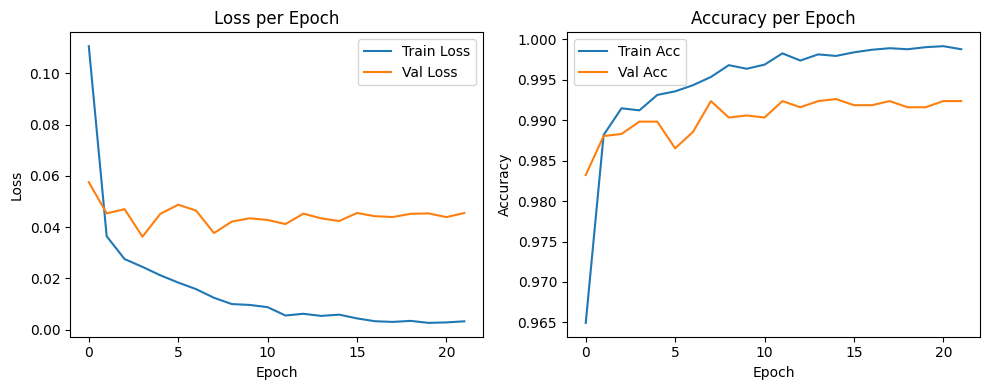

In [ ]:
import matplotlib.pyplot as plt

# Graph Loss
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

# Graph Accuracy
plt.subplot(1,2,2)
plt.plot(train_acc_history, label='Train Acc')
plt.plot(val_acc_history, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.tight_layout()
plt.show()

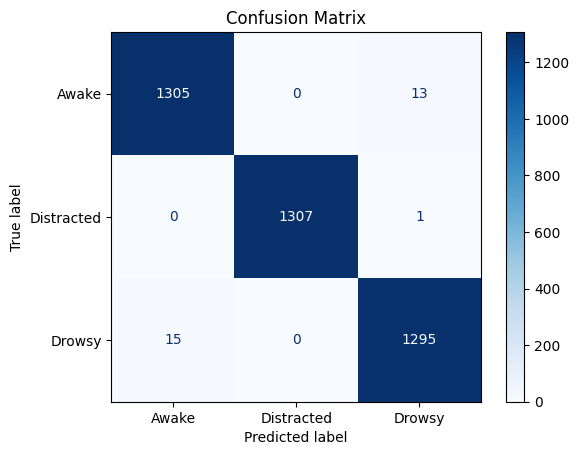

              precision    recall  f1-score   support

       Awake       0.99      0.99      0.99      1318
  Distracted       1.00      1.00      1.00      1308
      Drowsy       0.99      0.99      0.99      1310

    accuracy                           0.99      3936
   macro avg       0.99      0.99      0.99      3936
weighted avg       0.99      0.99      0.99      3936



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import pandas as pd

# ລຳດັບ class ແນ່ນອນ
class_names = ['Awake', 'Distracted', 'Drowsy']
label_indices = [0, 1, 2]  # index ตาม ImageFolder

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds, labels=label_indices)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Classification Report
report = classification_report(all_labels, all_preds, labels=label_indices, target_names=class_names)
print(report)
